https://www.kaggle.com/competitions/m5-forecasting-accuracy

In [ ]:
import joblib
import numpy as np
import pandas as pd
import optuna
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
calendar = pd.read_csv(r'./data/calendar.csv')
calendar

date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0        0   
1              NaN          NaN           NaN          NaN        0        0   
2              NaN          NaN           NaN          NaN        0        0   
3              NaN          NaN           NaN          NaN        1        1   
4              NaN          NaN           NaN          NaN        1        0   
...            ...          ...           ...          ...      ...      ...   
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0  

[1969 rows x 14 columns]

In [3]:
sales = pd.read_csv('./data/sales_train_validation.csv')
sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
0         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
1         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
2         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
3         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
4         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
...        ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
30485     WI_3       WI    0    0    2    2    0    3    1    4    1     0   
30486     WI_3       WI    0    0    0    0    0    5    0    1    1     3   
30487     WI_3       WI    0    6    0    2    2    4    1    8    5     2   
30488     WI_3       WI    0    0    0    0    0    0    0    0    0     0   
30489     WI_3       WI    0    0    0    0    0    0    0    0    0     0   

       d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
30485     0     3     4     4     0     0     1     0     1     1     7     7   
30486     1     1     0     4     2     0     1     2     1     1     0     0   
30487     7     5     3     5    20     8    10     3     3     4     7     2   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
30485     3     6     3     3     7    12     4     2     7     5    12     5   
30486     0     0     3     1     1     1     2     0     1     0     1     1   
30487     3     5     6     3     4     1     2     5     1     2     2     2   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2      

In [4]:
prices = pd.read_csv('./data/sell_prices.csv')
prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [5]:
day_cols = [c for c in sales.columns if c.startswith('d_')]
tmp = sales.groupby(['state_id', 'store_id', 'item_id'], as_index=False)[day_cols].sum()
tmp = tmp.melt(
    id_vars=['state_id', 'store_id', 'item_id'],
    value_vars=day_cols,
    var_name='d',
    value_name='sales'
)
tmp.head()

state_id store_id      item_id    d  sales
0       CA     CA_1  FOODS_1_001  d_1      3
1       CA     CA_1  FOODS_1_002  d_1      0
2       CA     CA_1  FOODS_1_003  d_1      0
3       CA     CA_1  FOODS_1_004  d_1      0
4       CA     CA_1  FOODS_1_005  d_1      3

In [6]:
tmp = pd.merge(tmp, calendar[['d', 'wm_yr_wk', 'date']], how='left', on='d')
tmp = pd.merge(tmp, prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])
tmp

state_id store_id          item_id       d  sales  wm_yr_wk  \
0              CA     CA_1      FOODS_1_001     d_1      3     11101   
1              CA     CA_1      FOODS_1_002     d_1      0     11101   
2              CA     CA_1      FOODS_1_003     d_1      0     11101   
3              CA     CA_1      FOODS_1_004     d_1      0     11101   
4              CA     CA_1      FOODS_1_005     d_1      3     11101   
...           ...      ...              ...     ...    ...       ...   
58327365       WI     WI_3  HOUSEHOLD_2_512  d_1913      0     11613   
58327366       WI     WI_3  HOUSEHOLD_2_513  d_1913      0     11613   
58327367       WI     WI_3  HOUSEHOLD_2_514  d_1913      0     11613   
58327368       WI     WI_3  HOUSEHOLD_2_515  d_1913      0     11613   
58327369       WI     WI_3  HOUSEHOLD_2_516  d_1913      0     11613   

                date  sell_price  
0         2011-01-29        2.00  
1         2011-01-29        7.88  
2         2011-01-29        2.88  
3         2011-01-29         NaN  
4         2011-01-29        2.94  
...              ...         ...  
58327365  2016-04-24        3.97  
58327366  2016-04-24        2.78  
58327367  2016-04-24       19.54  
58327368  2016-04-24        1.97  
58327369  2016-04-24        5.94  

[58327370 rows x 8 columns]

In [7]:
tmp['total_revenue'] = tmp.sales*tmp.sell_price
tmp = tmp.groupby(['state_id', 'date'], as_index=False).agg({'total_revenue': pd.Series.sum})
tmp.head()

state_id        date  total_revenue
0       CA  2011-01-29       36276.10
1       CA  2011-01-30       35047.46
2       CA  2011-01-31       25283.73
3       CA  2011-02-01       26917.00
4       CA  2011-02-02       25175.63

In [8]:
px.line(tmp.sort_values('date'), x='date', y='total_revenue', color='state_id', title='Выручка по дням')

<Axes: xlabel='total_revenue', ylabel='Count'>

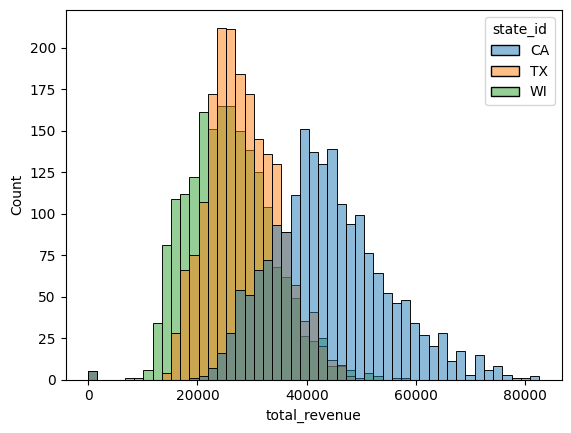

In [9]:
sns.histplot(tmp, x='total_revenue', hue='state_id')

In [10]:
tmp['date'] = pd.to_datetime(tmp['date'])
ax = tmp.set_index('date').groupby('state_id').resample('W')['total_revenue'].mean().reset_index()
px.line(ax.sort_values('date'), x='date', y='total_revenue', color='state_id', title='Выручка по неделям')

In [11]:
day_cols = [c for c in sales.columns if c.startswith("d_")]
long_sales = sales.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    value_vars=day_cols,
    var_name="d",
    value_name="sales"
)

In [12]:
tmp = long_sales.groupby(['state_id', 'd'], as_index=False).agg(sales=('sales', pd.Series.sum))
tmp = pd.merge(tmp, calendar[['d', 'date']], how='left', on='d')

tmp = tmp.sort_values(['state_id', 'date'])
tmp['rolling_mean'] = tmp.sales.rolling(7).mean()
px.line(tmp, x='date', y='rolling_mean', color='state_id', title='Скользящее среднее(7) кол-ва продаж')

In [13]:
del tmp, ax

In [14]:
X = long_sales.groupby(['d'], as_index=False).sales.sum()
X['d_int'] = X.d.str[2:].astype(int)
X = X.sort_values('d_int')
X.head()

d  sales  d_int
0     d_1  32631      1
1025  d_2  31749      2
1136  d_3  23783      3
1247  d_4  25412      4
1358  d_5  19146      5

In [15]:
X = pd.merge(X, calendar[['date', 'd']], how='left', on='d')
X.date = pd.to_datetime(X.date)

In [16]:
X['is_christmas_day'] = (X.date.dt.strftime("%d-%m") == '25-12').astype(int)

In [17]:
X_train = X[~X.d_int.between(X.d_int.max()-27, X.d_int.max())]
X_val = X[X.d_int.between(X.d_int.max()-27, X.d_int.max())]

Text(0.5, 1.0, 'Общее кол-во продаж')

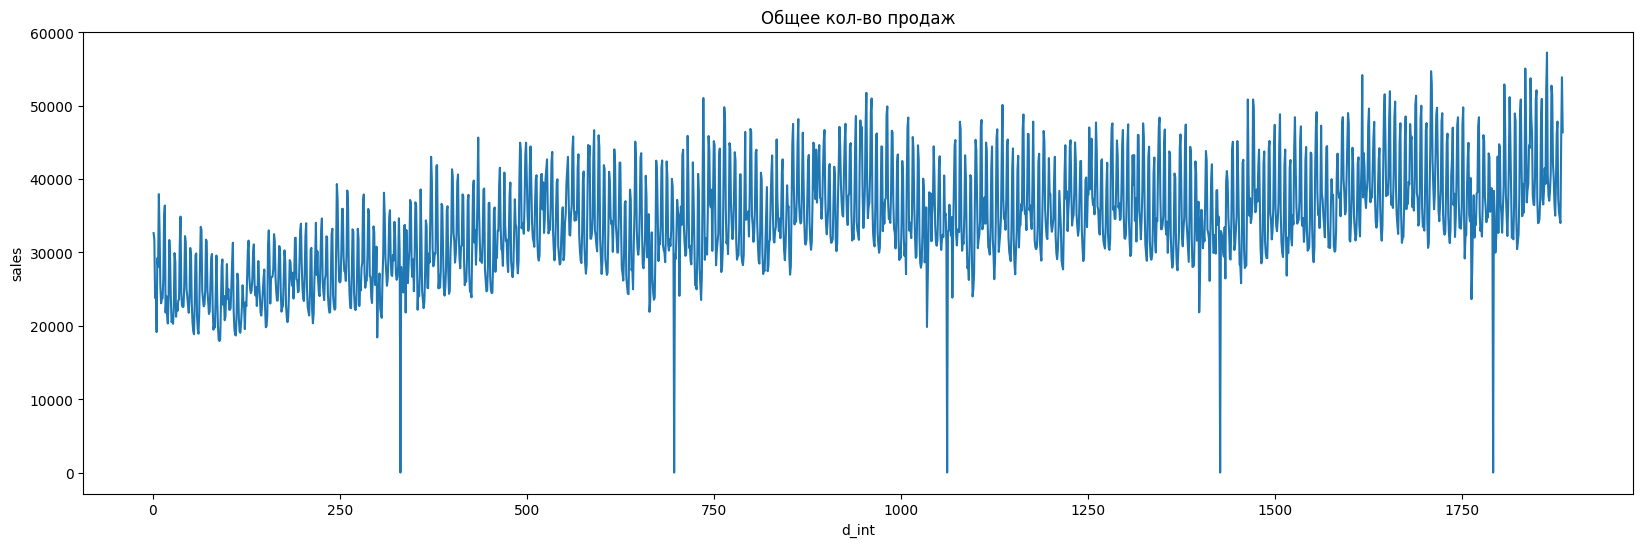

In [18]:
plt.figure(figsize=(20, 6))
sns.lineplot(X_train, x='d_int', y='sales')
plt.title('Общее кол-во продаж')

Будем предсказывать продажи.

Отыщем стационарность (слабую), т.е. когда математическое ожидание и дисперсия являются равными вне зависимости от времени: $\mu_X(t)=\mu_X$, $\mathrm{Var}(X_t)=\sigma_x^2$, где $X_1,...,X_n$ - временной ряд это реализация случайных величин во времени t.

Временной ряд можно разбить на 3 компоненты: $X_t = T_t + S_t + Y_t$, где

- $T_t$ - детерминестический тренд,
- $S_t$ - сезонные вариации,
- $Y_t$ - остаточная часть (стационарный процесс).

<Axes: xlabel='d_int', ylabel='linreg'>

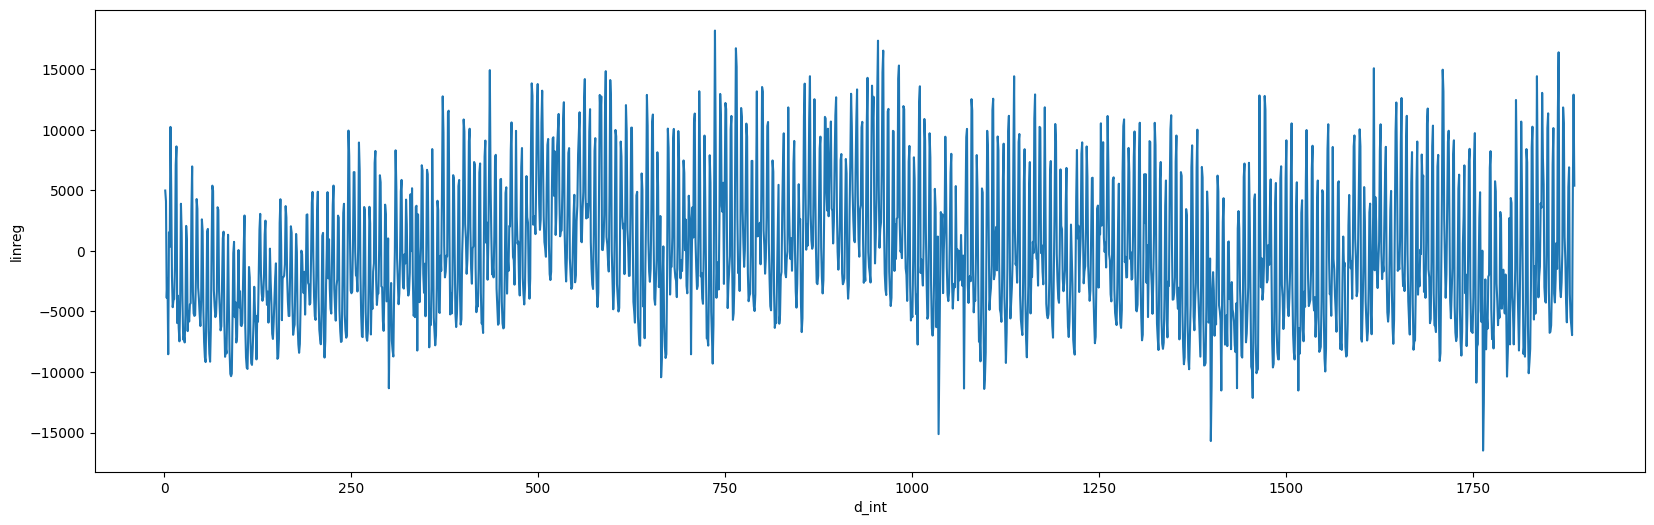

In [19]:
plt.figure(figsize=(20, 6))
base_cols = ['d_int', 'is_christmas_day']
model = LinearRegression().fit(X_train[base_cols], X_train.sales)
X_train['linreg'] = X_train.sales - (model.predict(X_train[base_cols])) 
sns.lineplot(X_train, x='d_int', y='linreg')

Избавились от линейного тренда и от выбросов.

In [20]:
X_train['quarter'] = X_train.date.dt.quarter
X_train = pd.concat((X_train, pd.get_dummies(X_train.quarter, prefix='quarter', drop_first=True).astype(int)), axis=1)
X_train.head()

d  sales  d_int       date  is_christmas_day       linreg  quarter  \
0  d_1  32631      1 2011-01-29                 0  4977.719131        1   
1  d_2  31749      2 2011-01-30                 0  4088.645149        1   
2  d_3  23783      3 2011-01-31                 0 -3884.428833        1   
3  d_4  25412      4 2011-02-01                 0 -2262.502815        1   
4  d_5  19146      5 2011-02-02                 0 -8535.576797        1   

   quarter_2  quarter_3  quarter_4  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0

<Axes: xlabel='d_int', ylabel='linreg_season'>

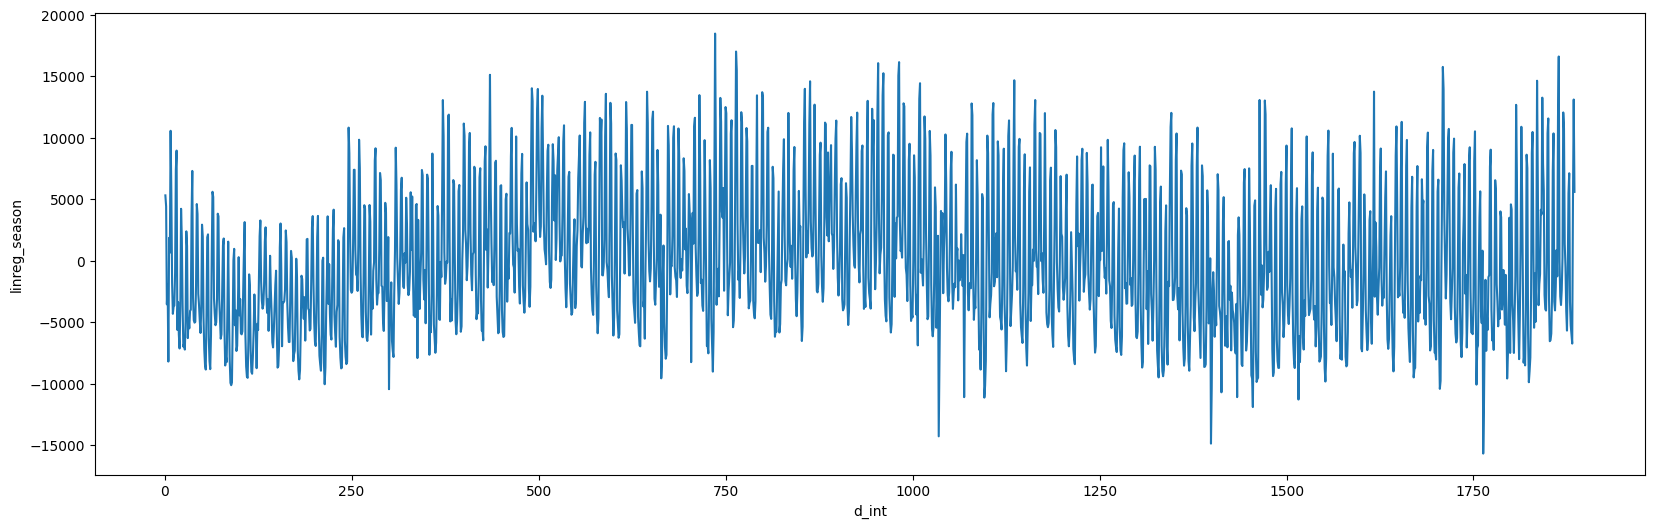

In [21]:
plt.figure(figsize=(20, 6))
quarters = base_cols + ['quarter_2', 'quarter_3', 'quarter_4']
model = LinearRegression().fit(X_train[quarters], X_train.sales)
X_train['linreg_season'] = X_train.sales - model.predict(X_train[quarters]) 
sns.lineplot(X_train, x='d_int', y='linreg_season')

Добавление сезона что-то не особо повлияло.

Добавим выходные и неделю месяца.

In [22]:
X_train['doff'] = X_train.date.dt.weekday
X_train['is_saturday'] = (X_train.doff == 5).astype(int)
X_train['is_sunday'] = (X_train.doff == 6).astype(int)
X_train['week_of_month'] = (X_train['date'].dt.day - 1) // 7 + 1
X_train = pd.concat((X_train, pd.get_dummies(X_train.week_of_month, prefix='dom').astype(int)), axis=1)

<Axes: xlabel='d_int', ylabel='linreg_season_doff_dom'>

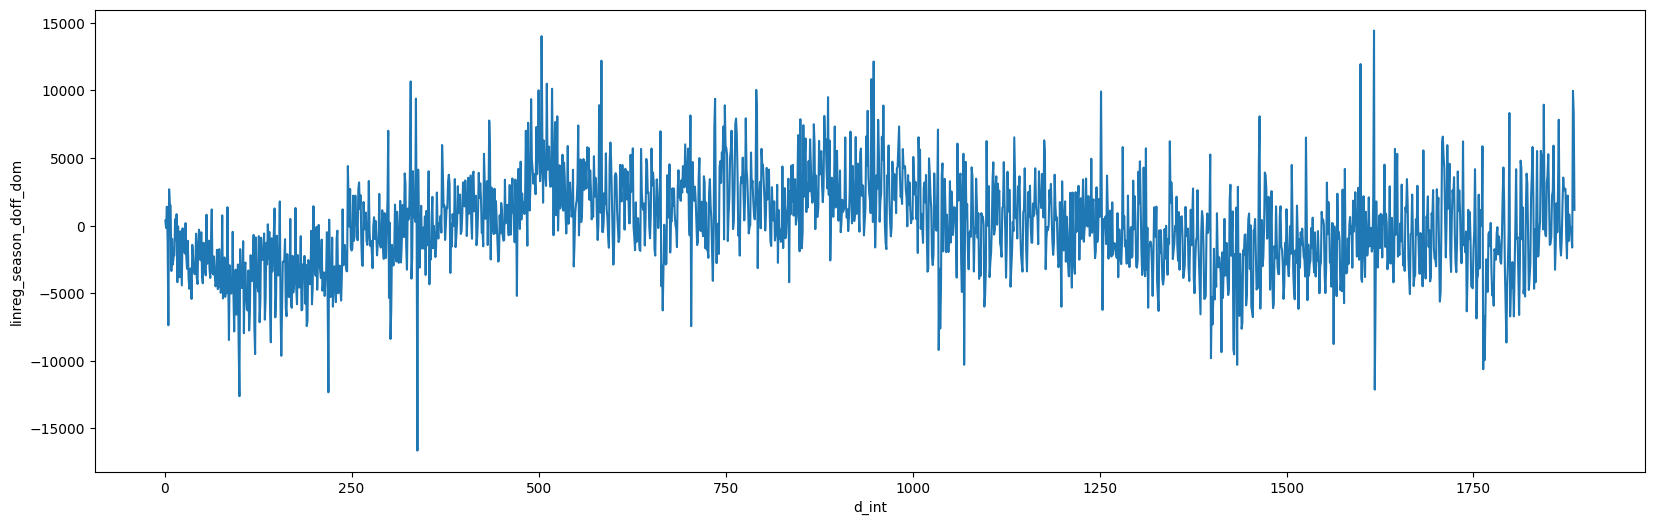

In [23]:
plt.figure(figsize=(20, 6))
quarter_dom_ddof = quarters + ['is_saturday', 'is_sunday', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5']
model = LinearRegression().fit(X_train[quarter_dom_ddof], X_train.sales)
X_train['linreg_season_doff_dom'] = X_train.sales - model.predict(X_train[quarter_dom_ddof]) 
sns.lineplot(X_train, x='d_int', y='linreg_season_doff_dom')

Дисперсия уменьшилась

Попробуем прологарифмировать таргет и построим линейную регрессию

<Axes: xlabel='d_int', ylabel='log_linreg'>

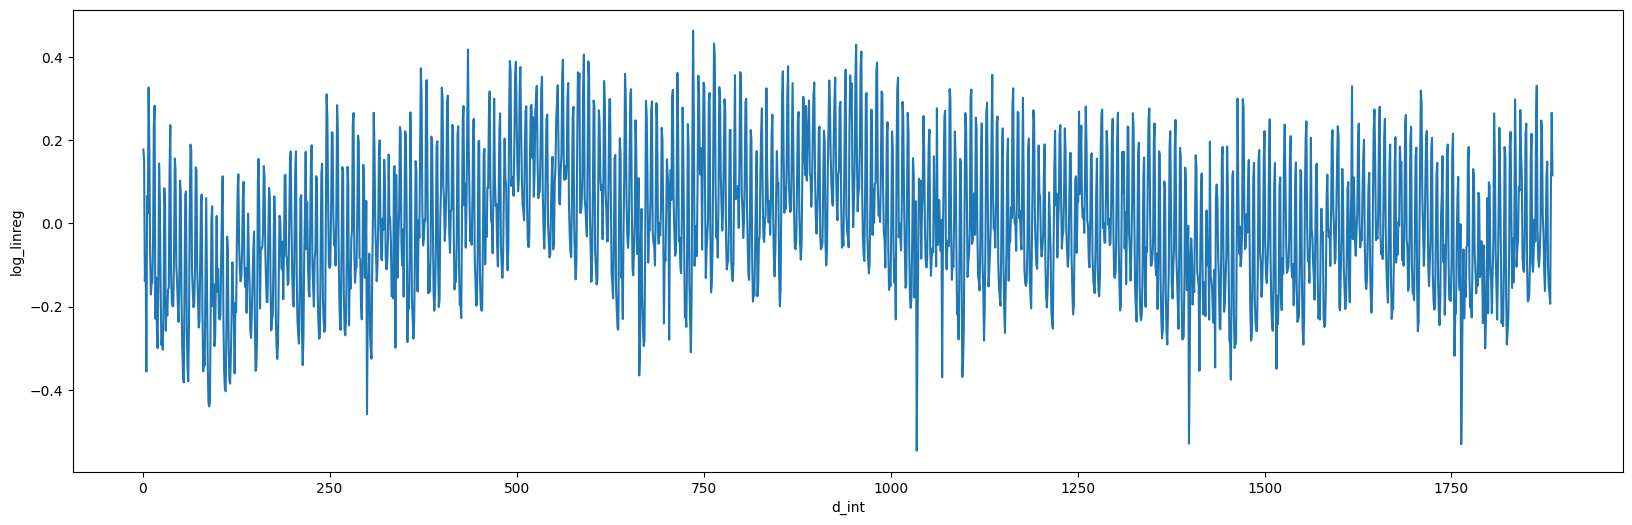

In [24]:
plt.figure(figsize=(20, 6))
model = LinearRegression().fit(X_train[base_cols], np.log(X_train.sales))
X_train['log_linreg'] = np.log(X_train.sales) - (model.predict(X_train[base_cols])) 
sns.lineplot(X_train, x='d_int', y='log_linreg')

<Axes: xlabel='d_int', ylabel='log_linreg_ddof_dom'>

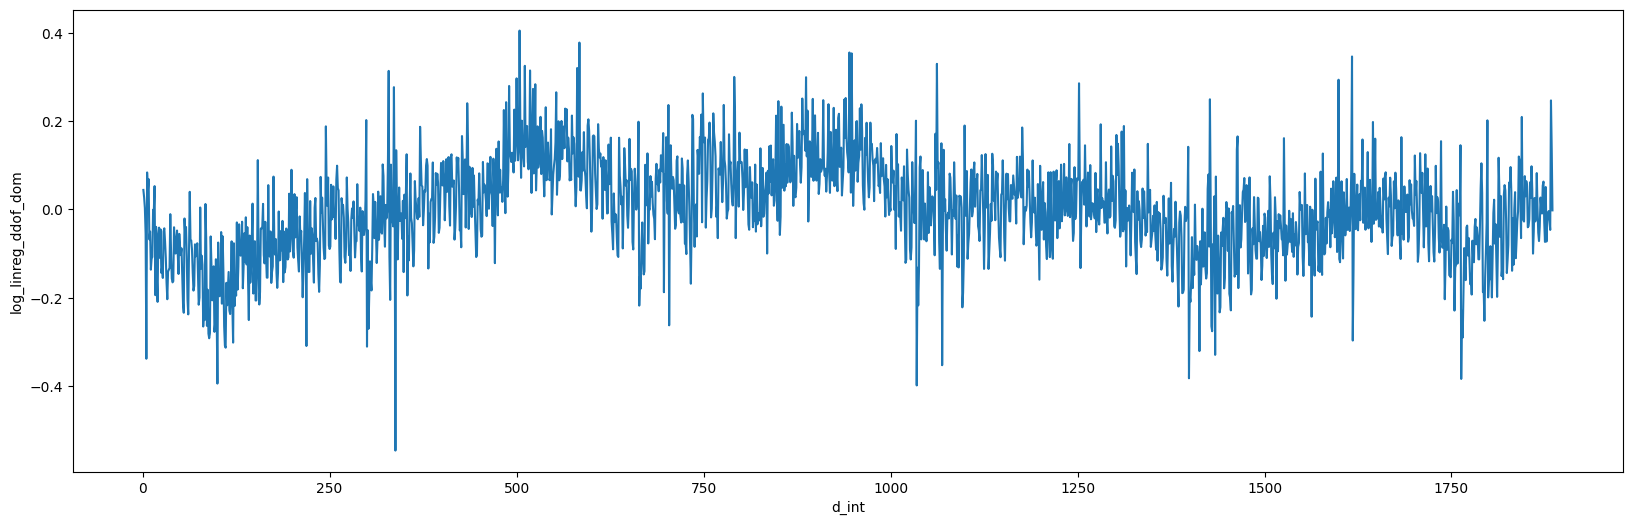

In [25]:
plt.figure(figsize=(20, 6))
ddof_dom = base_cols + ['is_saturday', 'is_sunday', 'dom_1', 'dom_2', 'dom_3', 'dom_4']
model = LinearRegression().fit(X_train[ddof_dom], np.log(X_train.sales))
X_train['log_linreg_ddof_dom'] = np.log(X_train.sales) - model.predict(X_train[ddof_dom])
sns.lineplot(X_train, x='d_int', y='log_linreg_ddof_dom')

Добавим сезон

<Axes: xlabel='d_int', ylabel='log_linreg_season_ddof_dom'>

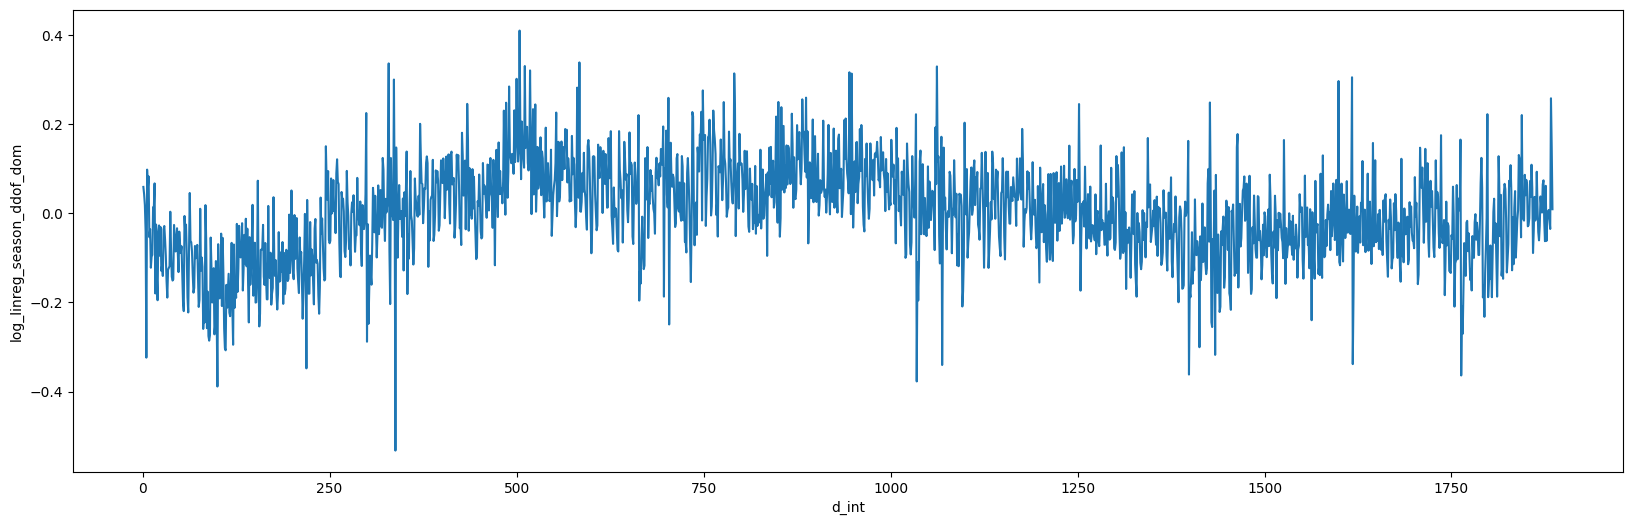

In [26]:
plt.figure(figsize=(20, 6))
model = LinearRegression().fit(X_train[quarter_dom_ddof], np.log(X_train.sales))
X_train['log_linreg_season_ddof_dom'] = np.log(X_train.sales) - model.predict(X_train[quarter_dom_ddof])
sns.lineplot(X_train, x='d_int', y='log_linreg_season_ddof_dom')

quarter(сезон) не влияет на значения практически никак.

Посмотрим, что будет если продифференцировать ряд:

<Axes: xlabel='d_int', ylabel='diff_1'>

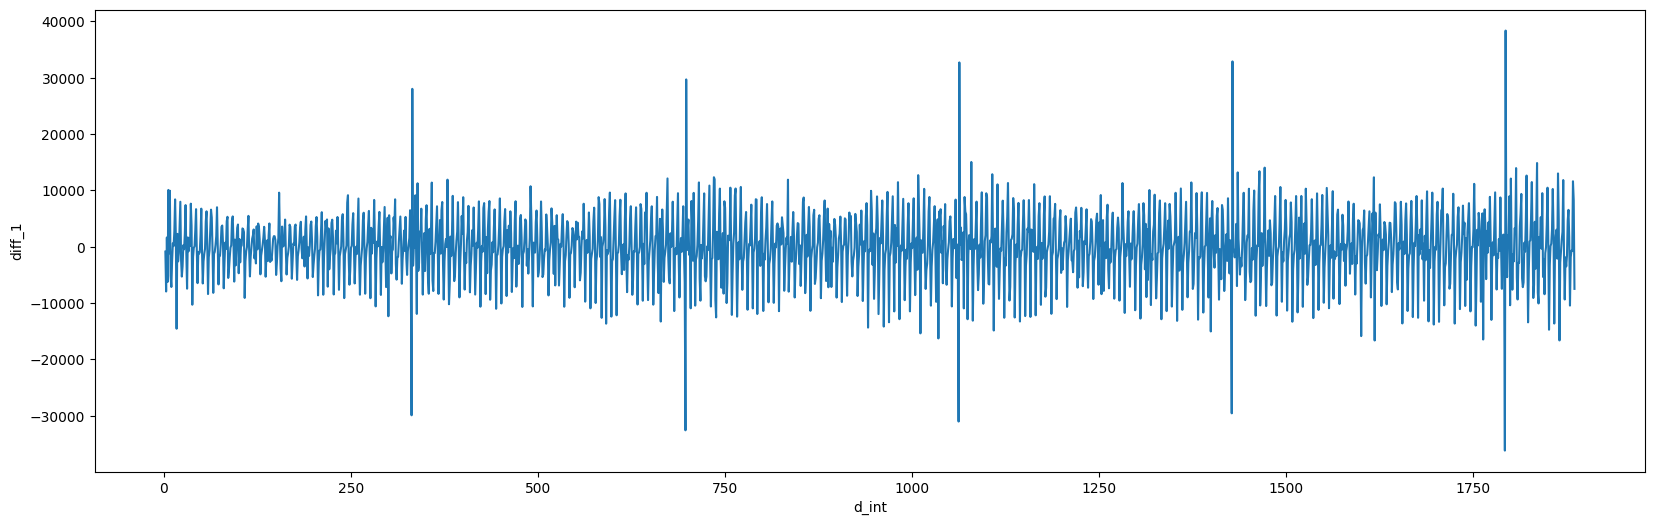

In [27]:
plt.figure(figsize=(20, 6))
X_train['diff_1'] = X_train.sales.diff(1)
sns.lineplot(X_train, x='d_int', y='diff_1')

Дважды продифференцировать:

<Axes: xlabel='d_int', ylabel='diff_2'>

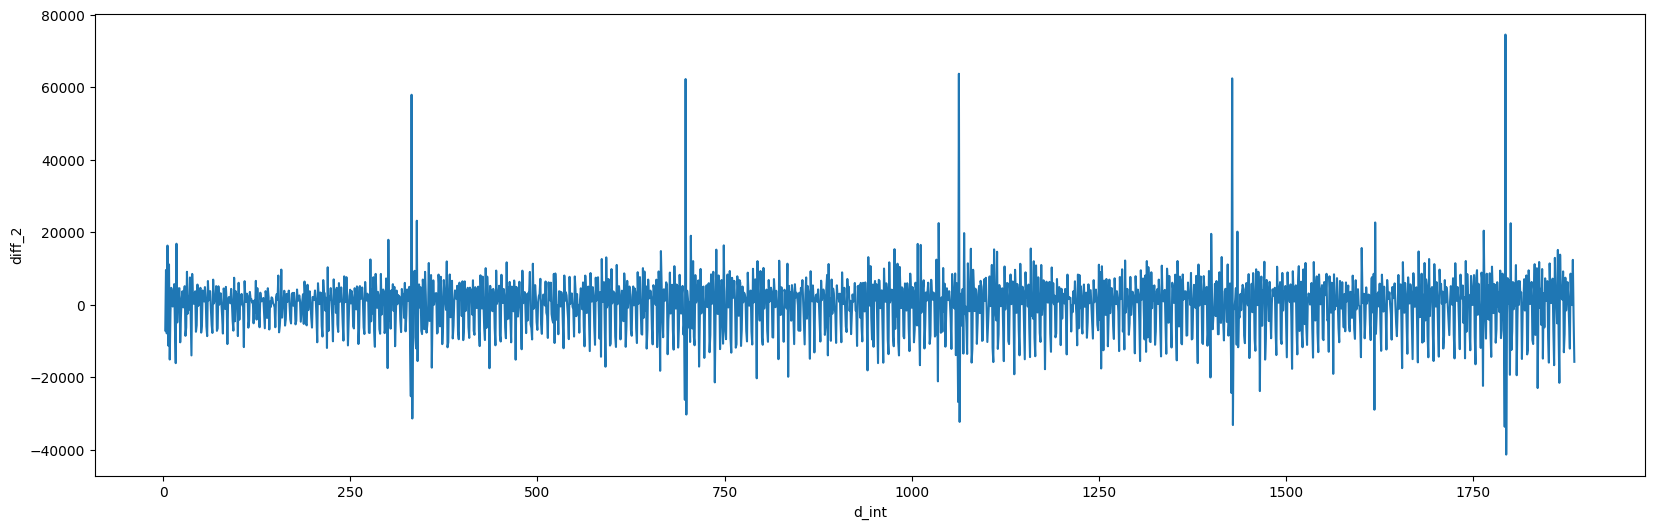

In [28]:
plt.figure(figsize=(20, 6))
X_train['diff_2'] = X_train.sales.diff().diff()
sns.lineplot(X_train, x='d_int', y='diff_2')

Посмотрим коррелограммы:

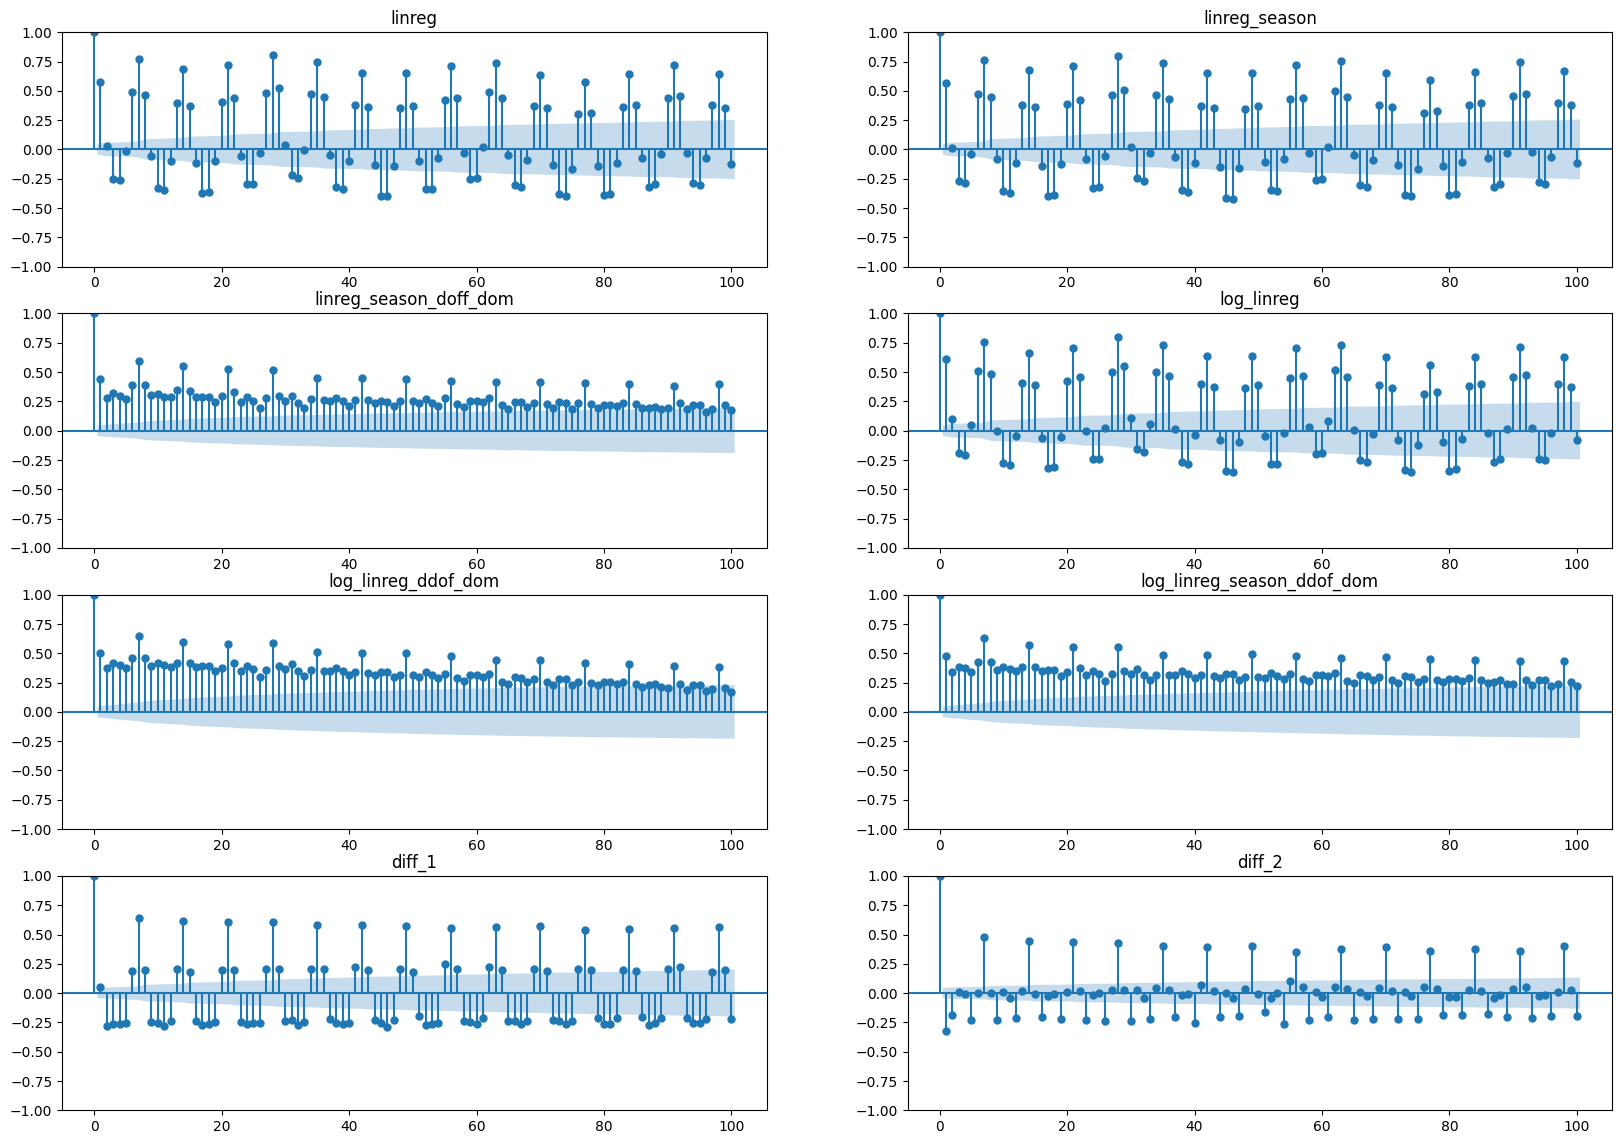

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(20, 14))

plot_acf(X_train.linreg, lags=100, title='linreg', ax=ax[0,0])
plot_acf(X_train.linreg_season, lags=100, title='linreg_season', ax=ax[0,1])
plot_acf(X_train.linreg_season_doff_dom, lags=100, title='linreg_season_doff_dom', ax=ax[1,0])
plot_acf(X_train.log_linreg, lags=100, title='log_linreg', ax=ax[1,1])
plot_acf(X_train.log_linreg_ddof_dom, lags=100, title='log_linreg_ddof_dom', ax=ax[2,0])
plot_acf(X_train.log_linreg_season_ddof_dom, lags=100, title='log_linreg_season_ddof_dom', ax=ax[2,1])
plot_acf(X_train.diff_1.dropna(), lags=100, title='diff_1', ax=ax[3,0]);
plot_acf(X_train.diff_2.dropna(), lags=100, title='diff_2', ax=ax[3,1]);

**linreg, linreg_season, log_linreg**: видна выраженная периодическая автокорреляция (пики на лагах, кратных 7). Это означает, что в остатках осталась недельная сезонность -> модель не полностью объяснила структуру временного ряда, остатки не похожи на «белый шум».

**diff_1, diff_2**: после дифференцирования автокорреляция уменьшается, но всё ещё остаются регулярные пики.

**linreg_season_ddof_dom (и лог-версия)**: коррелограмма выглядит заметно плосче, практически исчезают регулярные пики на сезонных лагах, остатки ближе к белому шуму.

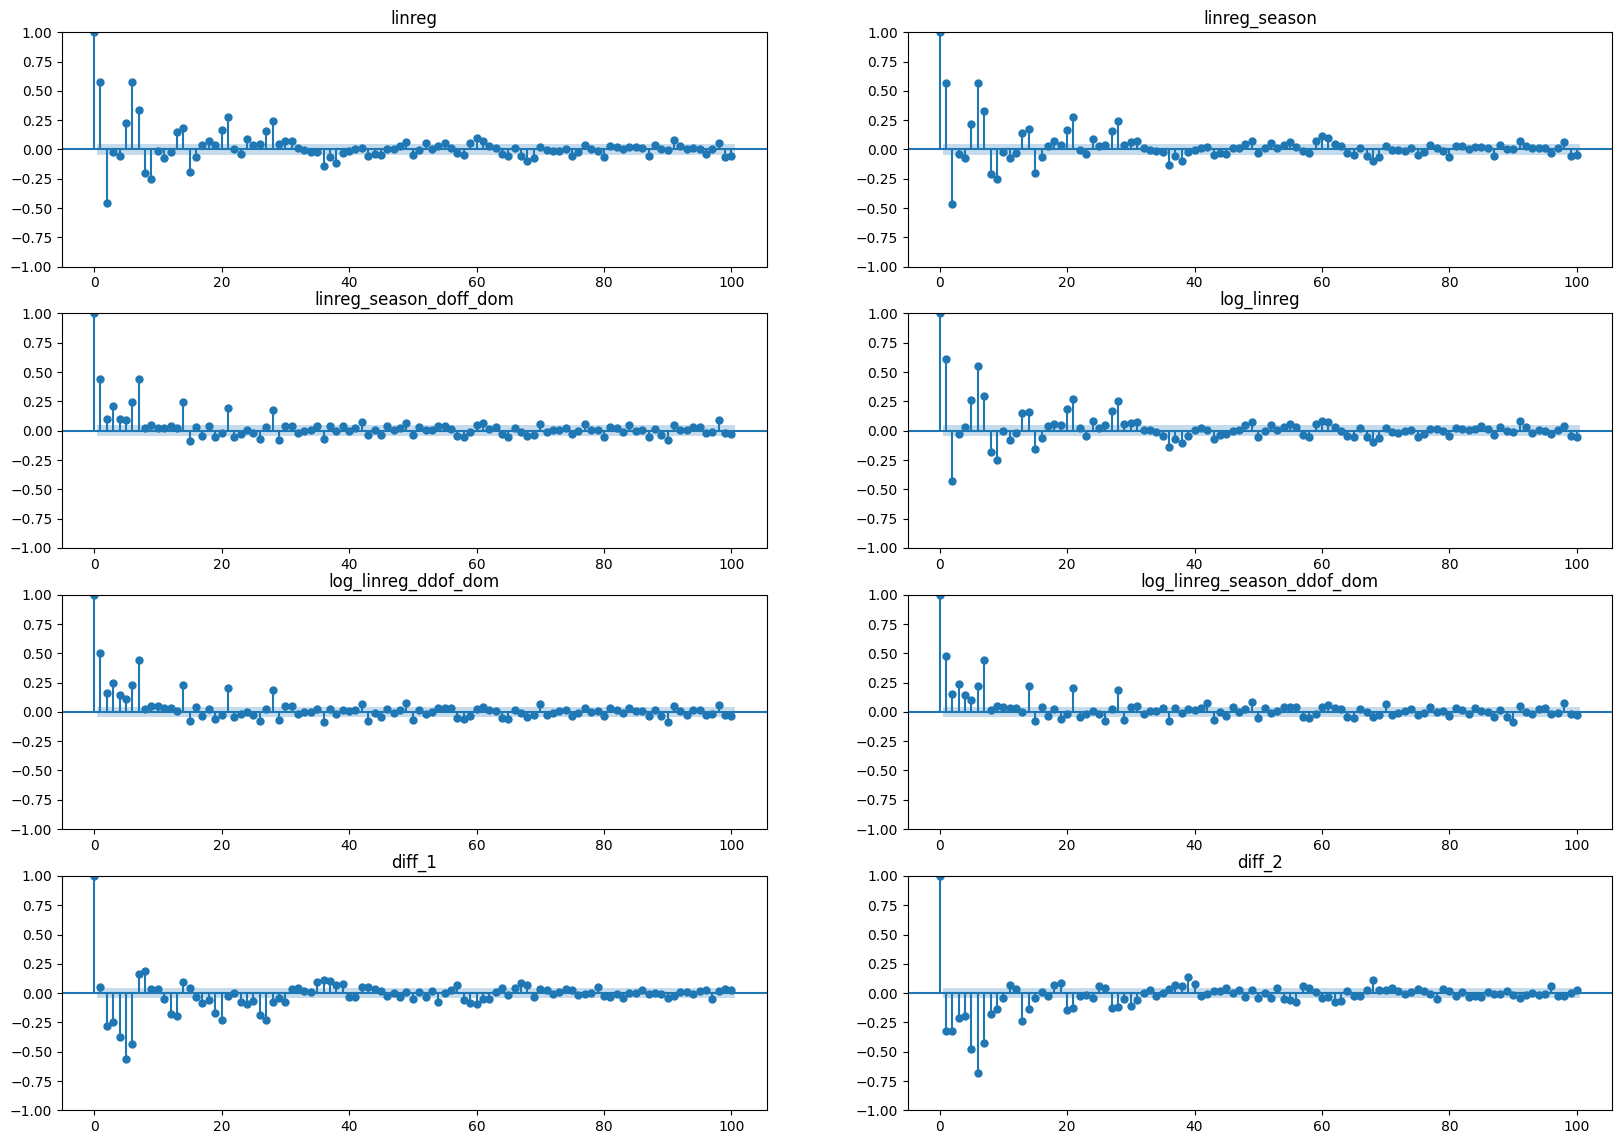

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(20, 14))

plot_pacf(X_train.linreg, lags=100, title='linreg', ax=ax[0,0])
plot_pacf(X_train.linreg_season, lags=100, title='linreg_season', ax=ax[0,1])
plot_pacf(X_train.linreg_season_doff_dom, lags=100, title='linreg_season_doff_dom', ax=ax[1,0])
plot_pacf(X_train.log_linreg, lags=100, title='log_linreg', ax=ax[1,1])
plot_pacf(X_train.log_linreg_ddof_dom, lags=100, title='log_linreg_ddof_dom', ax=ax[2,0])
plot_pacf(X_train.log_linreg_season_ddof_dom, lags=100, title='log_linreg_season_ddof_dom', ax=ax[2,1])
plot_pacf(X_train.diff_1.dropna(), lags=100, title='diff_1', ax=ax[3,0]);
plot_pacf(X_train.diff_2.dropna(), lags=100, title='diff_2', ax=ax[3,1]);

PACF практически для всех моделей показывает значимые пики на малых лагах, что указывает на наличие неучтённой авторегрессионной структуры в остатках.
Для модели linreg_season_ddof_dom (и её лог-версии) частные автокорреляции на большинстве лагов меньше и быстрее затухают.

## Прогнозирование

### Авторегриссионная модель

Авторегрессионная модель $AR(p)$ порядка $p$ это временной ряд вида: $X_t=\phi_1 X_{t-1} + \phi_2 X_{t-2} +...+ \phi_p X_{t-p} + W_t$, где $\{W_t\}_t$ это белый шум и $W_t$ некоррелирует с $X_s$ для $s<t$

Ввиду рекурсивности все реализации модели зависимы. Следовательно, австоковариация $\gamma_X(h)$ не равна нулю при увелечении лага и спадает экспоненциально.

<Axes: ylabel='sales'>

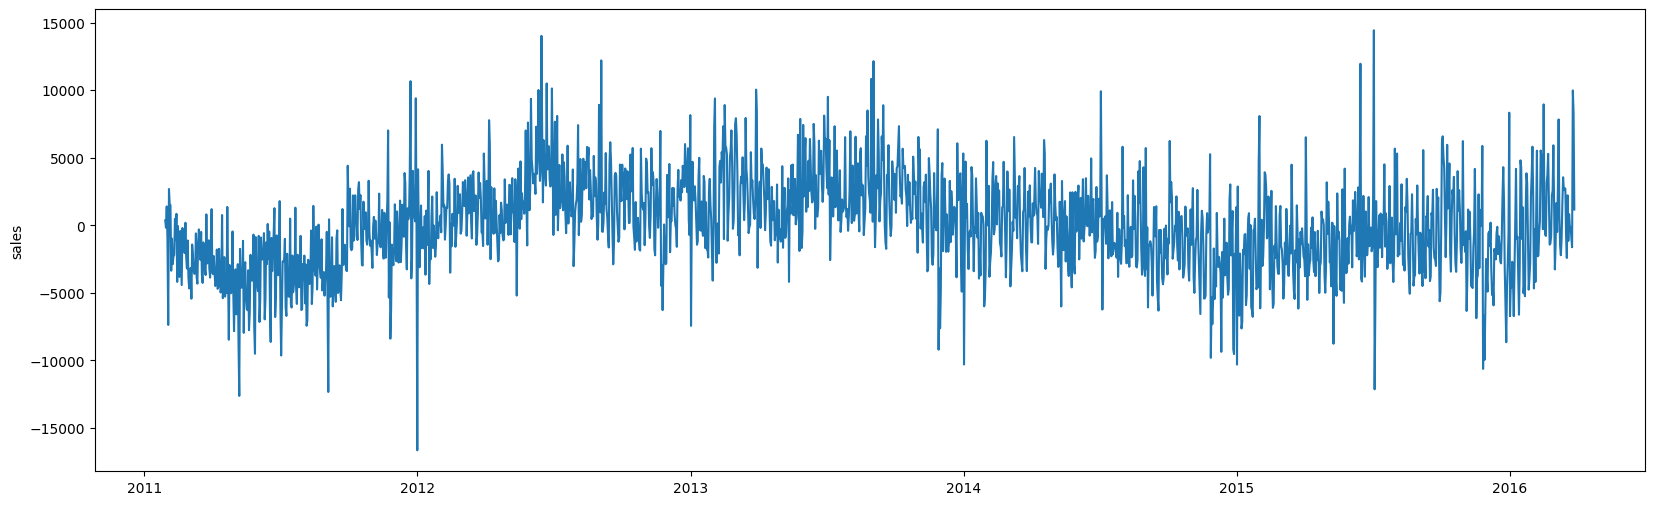

In [31]:
y = X_train.sales
X_train = X_train.set_index('date')[quarter_dom_ddof].drop(columns=['dom_1'])
y.index = pd.DatetimeIndex(X_train.index.values,
                               freq=X_train.index.inferred_freq)

model = LinearRegression().fit(X_train, y)
deterministic_part = model.predict(X_train)
residuals = y - deterministic_part
plt.figure(figsize=(20, 6))
sns.lineplot(residuals)

In [32]:
autoreg = AutoReg(residuals.to_numpy(), lags=[1, 3, 7, 28], seasonal=False, trend='n') # взяли не все лаги до t-p, а конкретно 3, 7, 28
autoreg = autoreg.fit()
print(autoreg.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1885
Model:             Restr. AutoReg(28)   Log Likelihood              -17201.175
Method:               Conditional MLE   S.D. of innovations           2550.246
Date:                Wed, 11 Feb 2026   AIC                          34412.350
Time:                        20:32:07   BIC                          34439.983
Sample:                            28   HQIC                         34422.534
                                 1885                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.2042      0.019     10.922      0.000       0.168       0.241
y.L3           0.0934      0.018      5.143      0.000       0.058       0.129
y.L7           0.3618      0.021     17.138      0.0

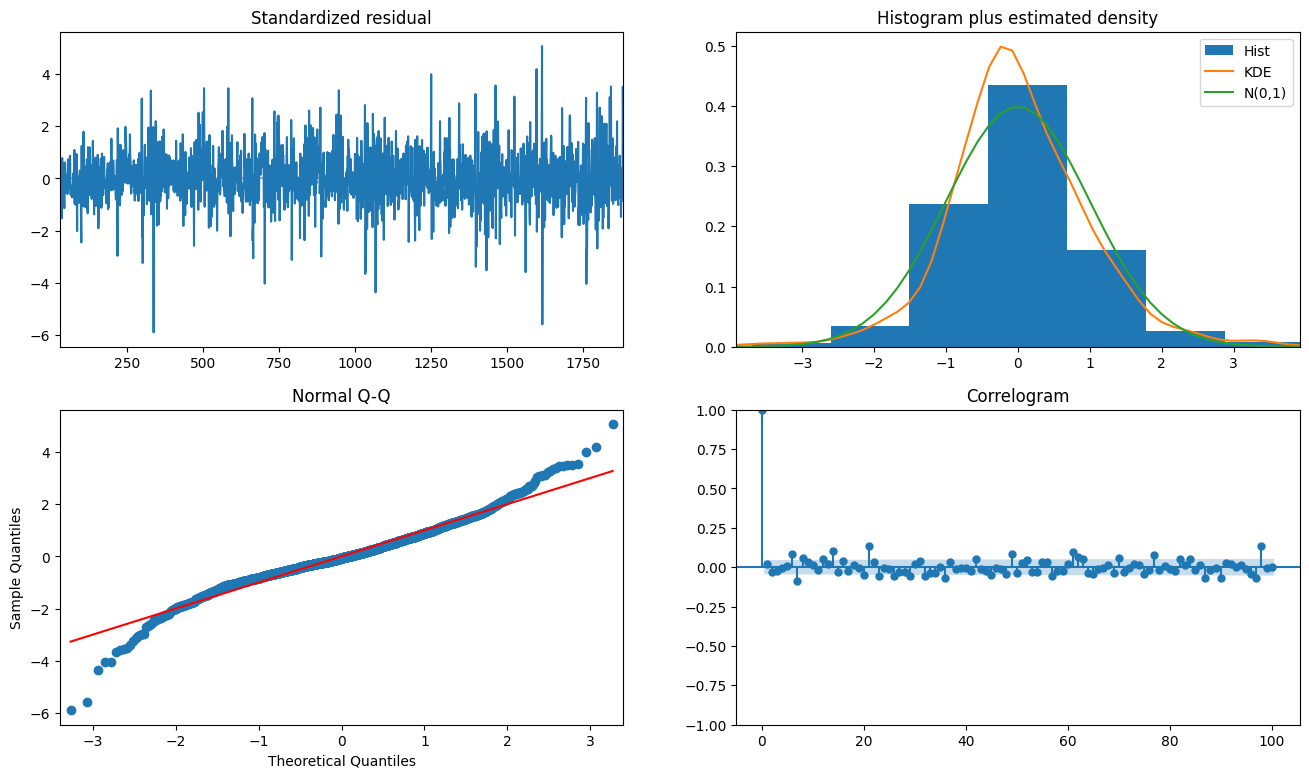

In [33]:
fig = plt.figure(figsize=(16, 9))
autoreg.plot_diagnostics(lags=100, fig=fig);

Попробуем предсказать на 28 дней вперед. Для этого сначала преобразуем валидационные данные:

In [34]:
X_train.tail()

d_int  is_christmas_day  quarter_2  quarter_3  quarter_4  \
date                                                                   
2016-03-23   1881                 0          0          0          0   
2016-03-24   1882                 0          0          0          0   
2016-03-25   1883                 0          0          0          0   
2016-03-26   1884                 0          0          0          0   
2016-03-27   1885                 0          0          0          0   

            is_saturday  is_sunday  dom_2  dom_3  dom_4  dom_5  
date                                                            
2016-03-23            0          0      0      0      1      0  
2016-03-24            0          0      0      0      1      0  
2016-03-25            0          0      0      0      1      0  
2016-03-26            1          0      0      0      1      0  
2016-03-27            0          1      0      0      1      0

In [35]:
X_val.head()

d  sales  d_int       date  is_christmas_day
1885  d_1886  36041   1886 2016-03-28                 0
1886  d_1887  33857   1887 2016-03-29                 0
1887  d_1888  32359   1888 2016-03-30                 0
1888  d_1889  34681   1889 2016-03-31                 0
1889  d_1890  45536   1890 2016-04-01                 0

In [36]:
X_val['quarter'] = X_val.date.dt.quarter
X_val['quarter_2'] = (X_val.quarter == 2).astype(int) 
X_val['quarter_3'] = (X_val.quarter == 3).astype(int) 
X_val['quarter_4'] = (X_val.quarter == 4).astype(int) 

X_val['is_saturday'] = (X_val.date.dt.weekday == 5).astype(int)
X_val['is_sunday'] = (X_val.date.dt.weekday == 6).astype(int)

X_val['week_of_month'] = (X_val['date'].dt.day - 1) // 7 + 1
X_val['dom_2'] = (X_val.week_of_month == 2).astype(int)
X_val['dom_3'] = (X_val.week_of_month == 3).astype(int)
X_val['dom_4'] = (X_val.week_of_month == 4).astype(int)
X_val['dom_5'] = (X_val.week_of_month == 5).astype(int)
X_val = X_val.drop(columns=['week_of_month', 'quarter', 'd'])
X_val = X_val.set_index('date')

In [37]:
y_val = X_val.sales
X_val = X_val.drop(columns='sales')

In [38]:
y_pred_autoreg = model.predict(X_val) + autoreg.predict(start=X_val.d_int.min()-1, end=X_val.d_int.max()-1, dynamic=True).shape

In [39]:
results = pd.concat((X_val[['d_int']], y_val,  pd.Series(y_pred_autoreg, index=y_val.index, name='autoreg')), axis=1)
results

d_int  sales       autoreg
date                                  
2016-03-28   1886  36041  35682.786863
2016-03-29   1887  33857  35910.263275
2016-03-30   1888  32359  35917.427693
2016-03-31   1889  34681  35924.592111
2016-04-01   1890  45536  40229.008822
2016-04-02   1891  52672  50127.502736
2016-04-03   1892  56425  49791.775098
2016-04-04   1893  40418  40250.502076
2016-04-05   1894  39683  40257.666494
2016-04-06   1895  39134  40264.830912
2016-04-07   1896  38116  40271.995330
2016-04-08   1897  43220  39665.921264
2016-04-09   1898  56340  49564.415178
2016-04-10   1899  53856  49228.687540
2016-04-11   1900  42427  39687.414518
2016-04-12   1901  39069  39694.578936
2016-04-13   1902  35193  39701.743355
2016-04-14   1903  37529  39708.907773
2016-04-15   1904  41789  37840.755366
2016-04-16   1905  48362  47739.249279
2016-04-17   1906  51640  47403.521642
2016-04-18   1907  38059  37862.248620
2016-04-19   1908  37570  37869.413038
2016-04-20   1909  35343  37876.577456
2016-04-21   1910  35033  37883.741874
2016-04-22   1911  40517  36038.590598
2016-04-23   1912  48962  45937.084511
2016-04-24   1913  49795  45601.356873

Предсказание:

<Axes: xlabel='d_int', ylabel='sales'>

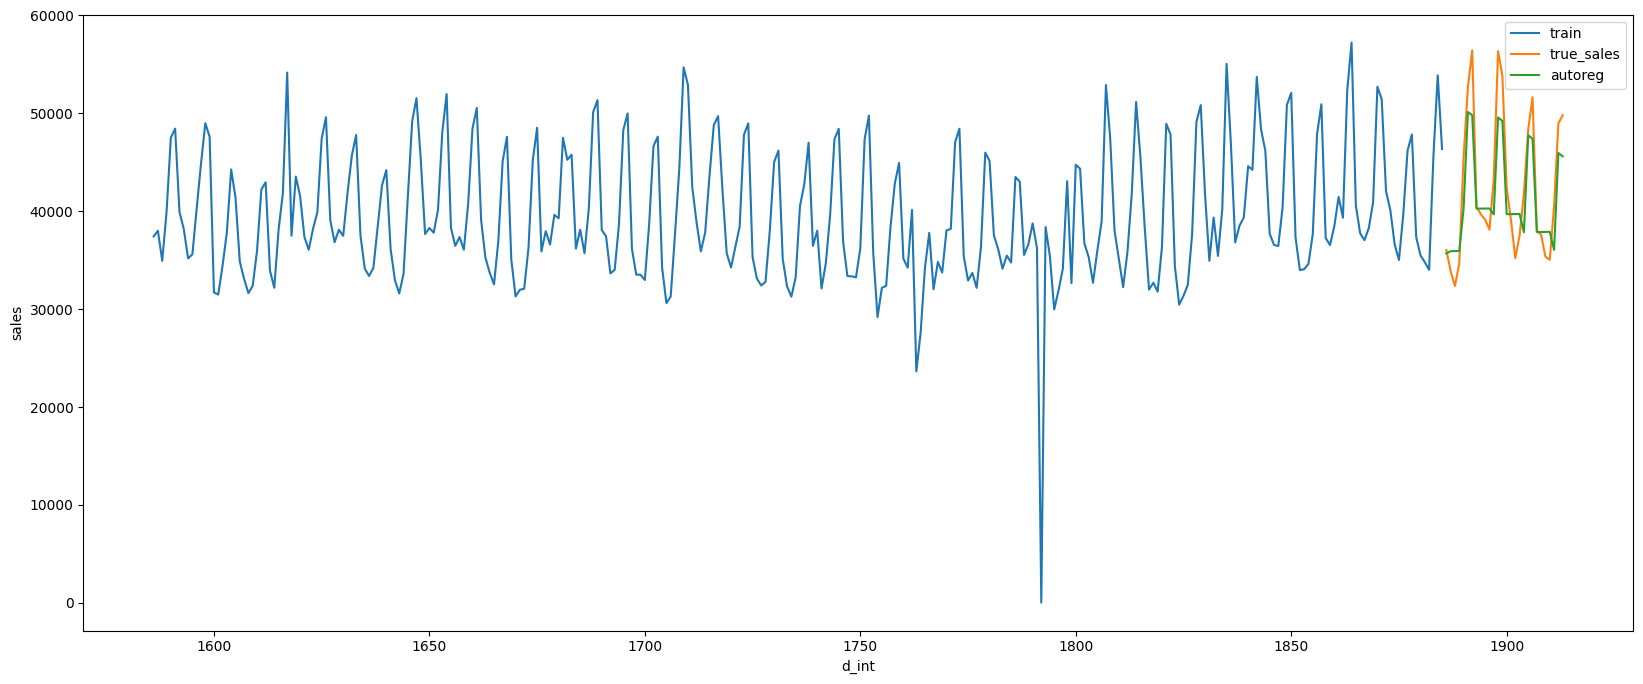

In [40]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X_train[-300:].d_int, y=y[-300:], label='train')
sns.lineplot(data=results, x='d_int', y='sales', label='true_sales')
sns.lineplot(data=results, x='d_int', y='autoreg', label='autoreg')

В целом, похоже на правду.

# ARMA

ARMA(p,q) это авторегрессионная модель со скользящим средним для стационарного ряда вида:

$$X_t=\phi_1 X_{t-1} + ... + \phi_p X_{t-p} + W_t + \theta_1 W_{t-1} + ... + \theta_q W_{t-q}$$

ARIMA это ARMA(p,q) после выполнения операции дифференцирования.

In [41]:
arma = ARIMA(residuals, order=([1, 3, 7, 28], 0, 3), trend='n').fit(method_kwargs={'maxiter':5000})

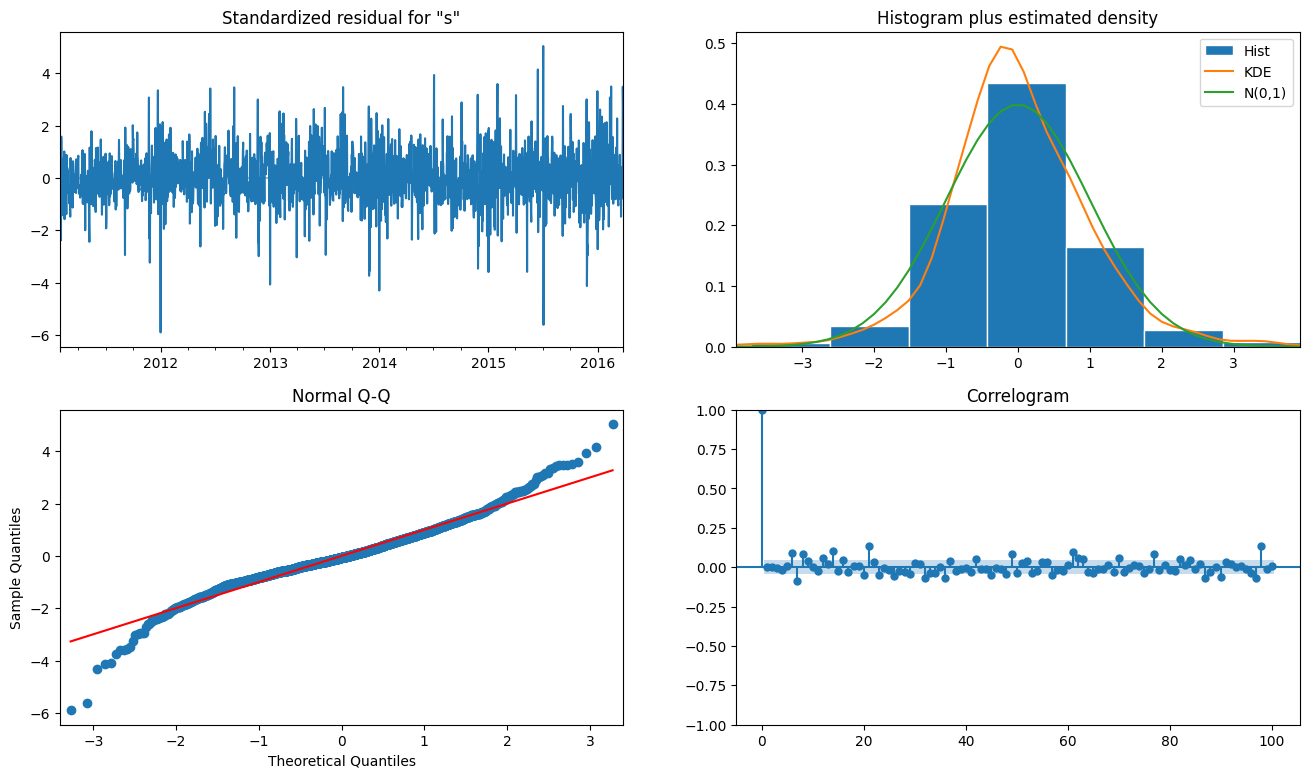

In [42]:
fig = plt.figure(figsize=(16, 9))
arma.plot_diagnostics(lags=100, fig=fig);

Предсказание остатка после линейной регресси по предыдущим точкам:

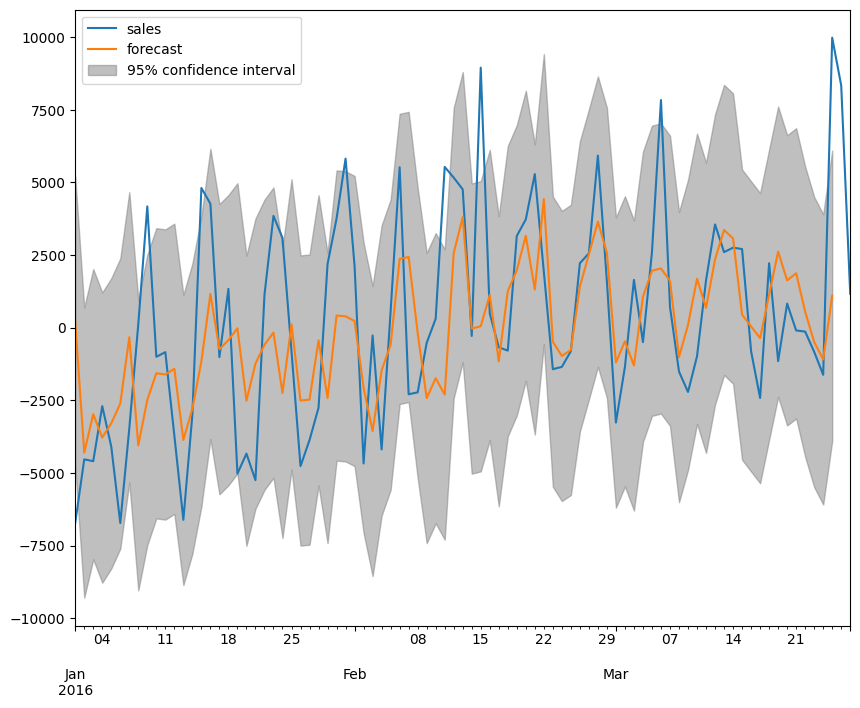

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = residuals.loc['2016-01-01':].plot(ax=ax)
fig = plot_predict(arma, dynamic=False, start='2016-01-01', end='2016-03-25', ax=ax)
legend = ax.legend(loc="upper left")

Просто предсказываем по датам:

In [44]:
start, end = '2016-03-28', pd.to_datetime('2016-03-28') + pd.Timedelta('27 days')
y_arima = model.predict(X_val) + arma.predict(start=start, end=end, dynamic=True)

In [47]:
results = pd.concat((results, y_arima.rename('arma')), axis=1)

<Axes: xlabel='d_int', ylabel='sales'>

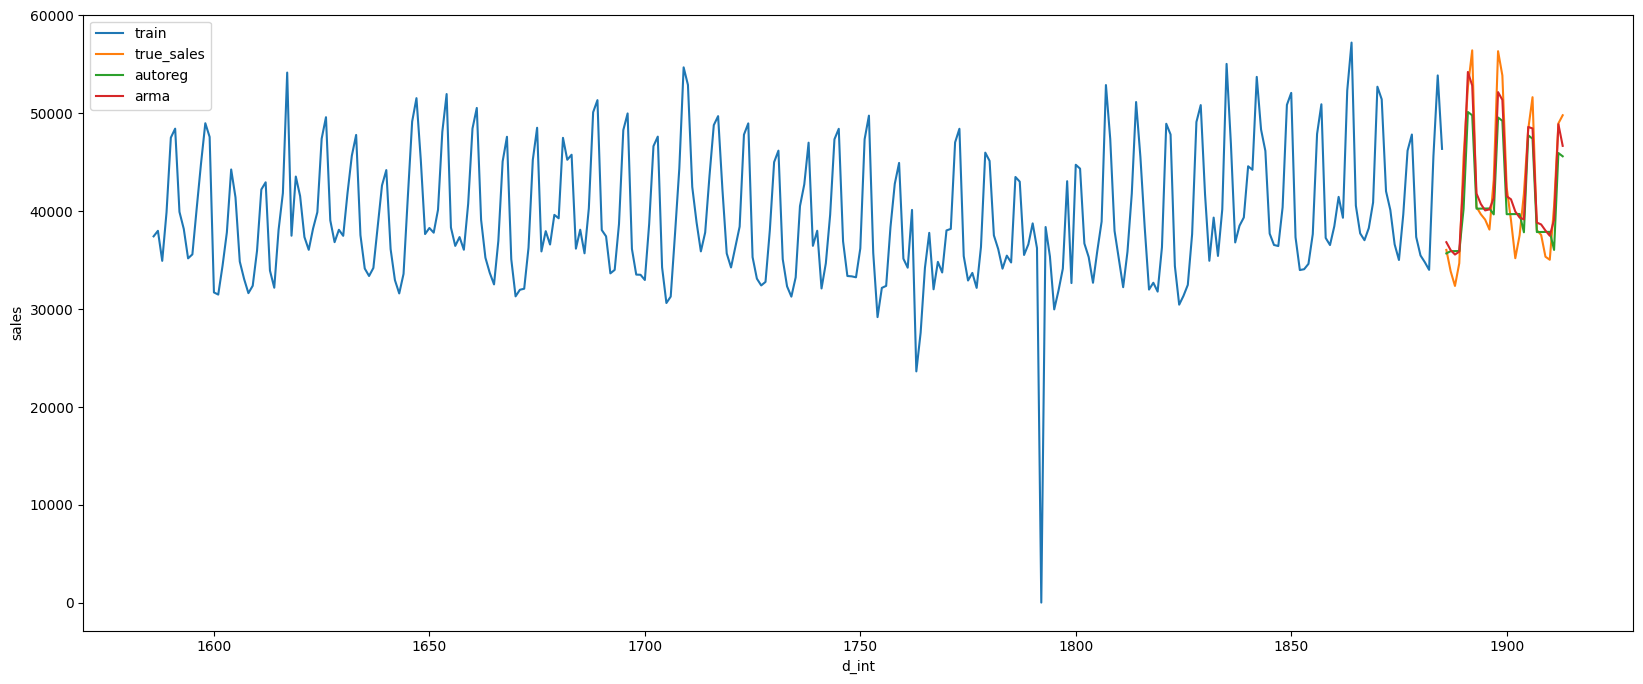

In [48]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X_train[-300:].d_int, y=y[-300:], label='train')
sns.lineplot(data=results, x='d_int', y='sales', label='true_sales')
sns.lineplot(data=results, x='d_int', y='autoreg', label='autoreg')
sns.lineplot(data=results, x='d_int', y='arma', label='arma')

Видно, что arma в нижних частях графика завышает прогнозы, как и авторегрессия. Но в пиках уже приближается в истинным значениям 

Попробуем обучить catboost для прогнозирования временного ряда. Тут придется химичить с фичами, а не со стационарностью.

In [ ]:
calendar.date = pd.to_datetime(calendar.date)
calendar = calendar.set_index('date')

In [ ]:
X.date = pd.to_datetime(X.date)
X = X.set_index('date')

In [ ]:
X_catboost = X.join(calendar[['weekday', 'month', 'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI']], how='left')
X_catboost.head()

d  sales  d_int  is_christmas_day    weekday  month  \
date                                                                
2011-01-29  d_1  32631      1                 0   Saturday      1   
2011-01-30  d_2  31749      2                 0     Sunday      1   
2011-01-31  d_3  23783      3                 0     Monday      1   
2011-02-01  d_4  25412      4                 0    Tuesday      2   
2011-02-02  d_5  19146      5                 0  Wednesday      2   

           event_name_1 event_name_2  snap_CA  snap_TX  snap_WI  
date                                                             
2011-01-29          NaN          NaN        0        0        0  
2011-01-30          NaN          NaN        0        0        0  
2011-01-31          NaN          NaN        0        0        0  
2011-02-01          NaN          NaN        1        1        0  
2011-02-02          NaN          NaN        1        0        1

In [ ]:
X_catboost['is_event'] = (X_catboost.event_name_1.notna() | X_catboost.event_name_2.notna()).astype(int)
X_catboost['snap_count'] = X_catboost.snap_TX + X_catboost.snap_CA + X_catboost.snap_WI


In [ ]:
X_catboost = X_catboost.drop(columns=['event_name_1', 'event_name_2', 'snap_CA', 
                                                  'snap_TX',	'snap_WI', 'd_int', 'd'])

Добавим номер недели в месяце

In [ ]:
week_of_month = (X_catboost.reset_index().date.dt.day - 1) // 7 + 1
week_of_month.index = X_catboost.index
X_catboost['week_of_month'] = week_of_month

Посчитаем значения ряда в предыдущих точках

In [ ]:
X_catboost['lag_1'] = X_catboost.sales.shift(1)
X_catboost['lag_3'] = X_catboost.sales.shift(3)
X_catboost['lag_7'] = X_catboost.sales.shift(7)
X_catboost['lag_28'] = X_catboost.sales.shift(28)
X_catboost['rolling_7'] = X_catboost.sales.shift(1).rolling(7).mean()
X_catboost['rolling_14'] = X_catboost.sales.shift(1).rolling(14).mean()
X_catboost['rolling_28'] = X_catboost.sales.shift(1).rolling(28).mean()
X_catboost = X_catboost.fillna(-1)

In [ ]:
X_catboost

sales  is_christmas_day    weekday  month  is_event  snap_count  \
date                                                                          
2011-01-29  32631                 0   Saturday      1         0           0   
2011-01-30  31749                 0     Sunday      1         0           0   
2011-01-31  23783                 0     Monday      1         0           0   
2011-02-01  25412                 0    Tuesday      2         0           2   
2011-02-02  19146                 0  Wednesday      2         0           2   
...           ...               ...        ...    ...       ...         ...   
2016-04-20  35343                 0  Wednesday      4         0           0   
2016-04-21  35033                 0   Thursday      4         0           0   
2016-04-22  40517                 0     Friday      4         0           0   
2016-04-23  48962                 0   Saturday      4         0           0   
2016-04-24  49795                 0     Sunday      4         0           0   

            week_of_month    lag_1    lag_3    lag_7   lag_28     rolling_7  \
date                                                                          
2011-01-29              5     -1.0     -1.0     -1.0     -1.0     -1.000000   
2011-01-30              5  32631.0     -1.0     -1.0     -1.0     -1.000000   
2011-01-31              5  31749.0     -1.0     -1.0     -1.0     -1.000000   
2011-02-01              1  23783.0  32631.0     -1.0     -1.0     -1.000000   
2011-02-02              1  25412.0  31749.0     -1.0     -1.0     -1.000000   
...                   ...      ...      ...      ...      ...           ...   
2016-04-20              3  37570.0  51640.0  35193.0  34786.0  41448.857143   
2016-04-21              3  35343.0  38059.0  37529.0  34003.0  41470.285714   
2016-04-22              4  35033.0  37570.0  41789.0  45611.0  41113.714286   
2016-04-23              4  40517.0  35343.0  48362.0  53863.0  40932.000000   
2016-04-24              4  48962.0  35033.0  51640.0  46360.0  41017.714286   

              rolling_14    rolling_28  
date                                    
2011-01-29     -1.000000     -1.000000  
2011-01-30     -1.000000     -1.000000  
2011-01-31     -1.000000     -1.000000  
2011-02-01     -1.000000     -1.000000  
2011-02-02     -1.000000     -1.000000  
...                  ...           ...  
2016-04-20  43021.714286  42449.964286  
2016-04-21  42750.928571  42469.857143  
2016-04-22  42530.714286  42506.642857  
2016-04-23  42337.642857  42324.714286  
2016-04-24  41810.642857  42149.678571  

[1913 rows x 14 columns]

<Axes: xlabel='sales', ylabel='Count'>

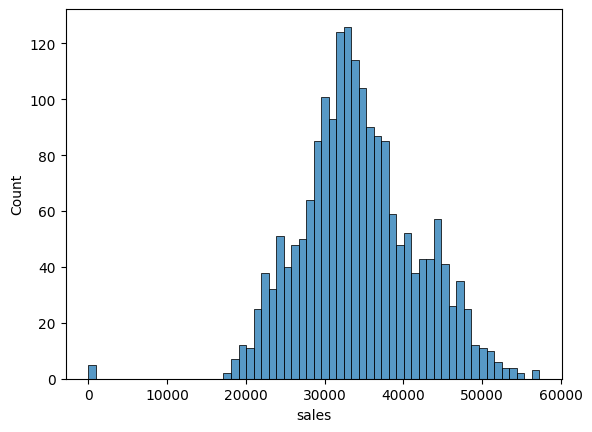

In [ ]:
sns.histplot(X_catboost.sales, bins=60)
plt.title('Распределение кол-ва продаж')

In [ ]:
best_params_catboost = {
    'loss_function': 'MAE',
    'learning_rate': 0.02,
    'depth': 6,
    'l2_leaf_reg': 3,
    'iterations': 2000,
    'random_strength': 1,
    'bagging_temperature': 1,
    'verbose': False,
    'random_seed': 33,
    'use_best_model': True,
    'task_type': 'CPU',
    'cat_features': ['weekday', 'month', 'snap_count', 'week_of_month'],
    'has_time': True
}

In [ ]:
X_train_catboost = X_catboost[:-28]
X_val_catboost = X_catboost[-28:]

In [ ]:
stop

In [ ]:
catboost_model = CatBoostRegressor(**best_params_catboost)
catboost_model.fit(X_train_catboost.drop(columns='sales'), X_train_catboost.sales,
                   eval_set=(X_val_catboost.drop(columns='sales'), X_val_catboost.sales), 
                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
catboost_model.get_best_iteration()

1325

In [ ]:
best_params_catboost.update({'iterations': 1000})#catboost_model.get_best_iteration()})

Подберем параметры регуляризации:

In [ ]:
params = best_params_catboost.copy()

tss = TimeSeriesSplit(test_size=28, n_splits=5)

def objective(trial):
    params.update({        
        "random_strength": trial.suggest_float("random_strength", 1e-5, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 30),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 1)
    })
    
    fold_maes = []

    for train_idx, val_idx in tss.split(X_train_catboost):
        train_df = X_train_catboost.iloc[train_idx]
        val_df   = X_train_catboost.iloc[val_idx]
        
        X_train = train_df.drop(columns='sales')
        y_train = train_df['sales']
        
        X_val = val_df.drop(columns='sales')
        y_val = val_df['sales']
        
        model = CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            verbose=False
        )
        
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        fold_maes.append(mae)
    
    return np.mean(fold_maes)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best = study.best_trial

[I 2026-02-10 17:19:11,415] A new study created in memory with name: no-name-47e70f55-6ed7-4cc6-bf0f-9997e3d70d8d
[I 2026-02-10 17:20:04,475] Trial 0 finished with value: 2621.666114141798 and parameters: {'random_strength': 0.37757669360248775, 'l2_leaf_reg': 14.22643351651585, 'bagging_temperature': 0.4685640742736541}. Best is trial 0 with value: 2621.666114141798.
[I 2026-02-10 17:20:53,608] Trial 1 finished with value: 2633.5859128820716 and parameters: {'random_strength': 0.6891288044854036, 'l2_leaf_reg': 28.210615779504455, 'bagging_temperature': 0.5771546339216808}. Best is trial 0 with value: 2621.666114141798.
[I 2026-02-10 17:21:46,891] Trial 2 finished with value: 2619.458709406538 and parameters: {'random_strength': 0.14764359002855174, 'l2_leaf_reg': 29.342396689766638, 'bagging_temperature': 0.27001787755494644}. Best is trial 2 with value: 2619.458709406538.
[I 2026-02-10 17:22:32,479] Trial 3 finished with value: 2579.533208607907 and parameters: {'random_strength': 8

In [ ]:
best_params_catboost.update(study.best_params)
# best_params_catboost.update(params)

del best_params_catboost['use_best_model']
del best_params_catboost['task_type']

In [ ]:
catboost_model = CatBoostRegressor(**best_params_catboost)
catboost_model.fit(X_train_catboost.drop(columns='sales'), X_train_catboost.sales)

In [ ]:
joblib.dump(catboost_model, r'./models/catboost_train.joblib')

['./models/catboost_train.joblib']

In [ ]:
catboost_model = joblib.load(r'./models/catboost_train.joblib')

Подготовим валидацию, а именно выкенем с нее все лаги и скользящие средние, т.к. они будут считаться с предсказаний модели, а не с истинных значений.

In [ ]:
X_val_catboost_forecast = X_val_catboost.drop(columns=['lag_1', 'lag_3', 'lag_7', 'lag_28', 'rolling_7', 'rolling_14', 'rolling_28'])

Функции, необходимые для валидации и предсказания. Берем исторические данные, берем день, на который хотим сделать предсказание. По историческим данным считаем лаги и скользящие средние для дня, продажи на который хотим прогнозировать. Закидываем эту строку в модель, записываем предсказание и конкатим эту строку к историческим данным. Повторяем. 

In [ ]:
def fill_lags_and_rollings_for_last_row(df, lags=(1,3,7,14,28), rollings=(7,14,28)):
    df = df.copy()
    
    y = df["sales"].values
    last_idx = df.index[-1]
    
    for l in lags:
        df.loc[last_idx, f"lag_{l}"] = y[-(l+1)] if len(y) > l else np.nan
    
    for w in rollings:
        hist = y[-(w+1):-1]  # последние w реальных значений
        df.loc[last_idx, f"rolling_{w}"] = np.mean(hist) if len(hist) == w else np.nan

    return df


def iterative_forecast(
    df_hist,
    df_future, 
    model=None,
    H=28,
    lags=[1, 3, 7, 28],
    roll_windows=[7, 14, 28]
):
    tmp = df_hist[-30:].copy()

    for step in range(H):
        cur_row = df_future.iloc[step]
        tmp = pd.concat([tmp, cur_row.to_frame().T], axis=0)
        tmp = fill_lags_and_rollings_for_last_row(tmp, lags, roll_windows)
        y_pred = model.predict(tmp.iloc[-1].drop('sales'))
        tmp.loc[tmp.index[-1], 'sales'] = y_pred


    return tmp[-H:]

In [ ]:
catboost = iterative_forecast(X_train_catboost, X_val_catboost_forecast.drop(columns='sales'), model=catboost_model)

In [ ]:
results = pd.concat((results, catboost.sales.rename('catboost')), axis=1)

<Axes: xlabel='d_int', ylabel='sales'>

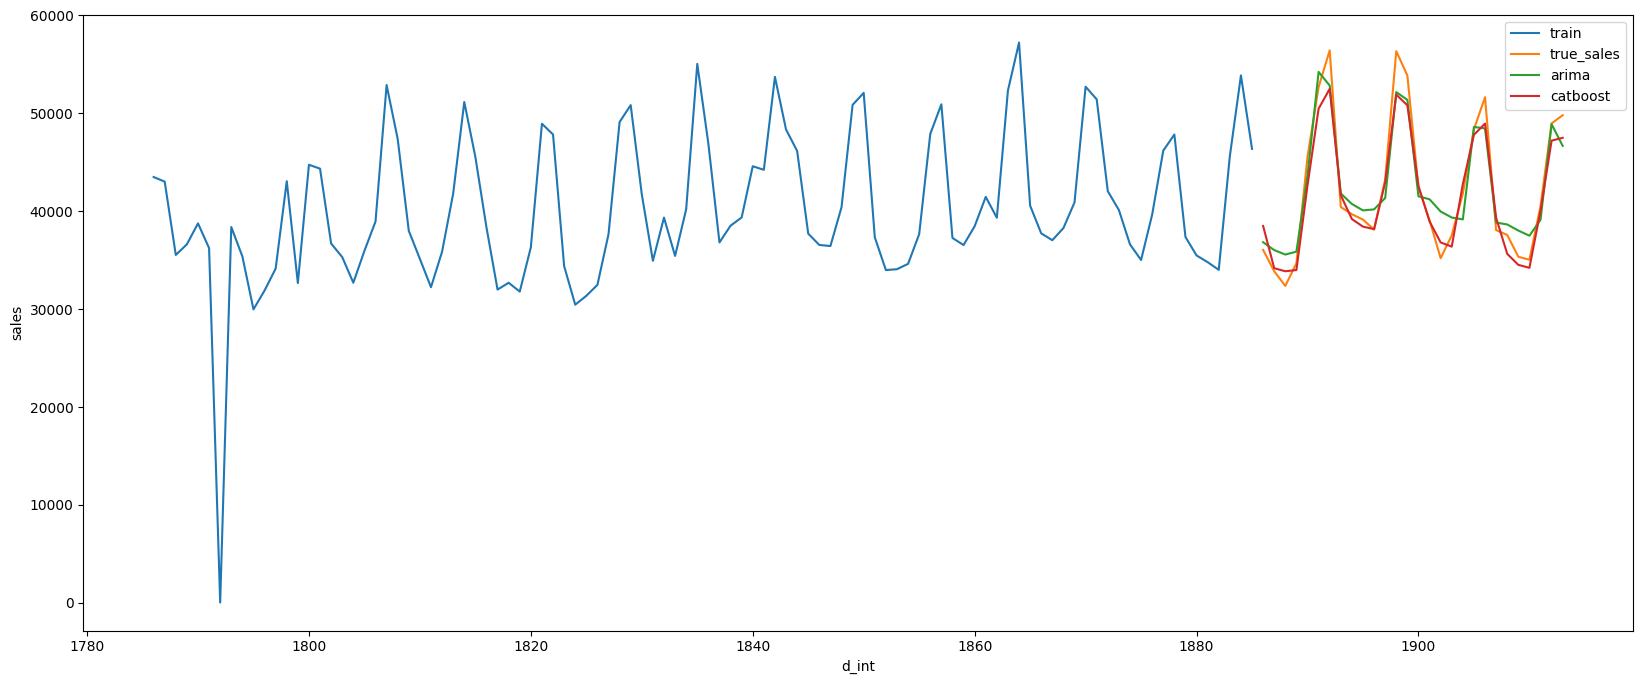

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X_train[-100:].d_int, y=y[-100:], label='train')
sns.lineplot(data=results, x='d_int', y='sales', label='true_sales')
# sns.lineplot(data=results, x='d_int', y='autoreg', label='autoreg')
sns.lineplot(data=results, x='d_int', y='arima', label='arima')
sns.lineplot(data=results, x='d_int', y='catboost', label='catboost')

Получилось, что модель практически во всем лучше arma, нижние точки предсказываеются практически идеально, а в верхних +- arma. Во всяком случае лучше немного занижать прогнозы, чем перепрогнозировать, чтобы потом не ловить неприятные сюрпризы :) 

Модель еще можно улучшать, добавляя всякие метрики по типу: "средние продажи в прошлом месяце" и тп. Построить свои модели для каждого штата. Построить композицию arima + catboost на остатках и тд.

То, ради чего я щупал этот датасет, было сделано. Попробую попрогнозировать то, что просят на kaggle. А именно, для каждого товара предсказать продажи в каждом магазине, в котором он продается.

Подготовим данные:

In [ ]:
del sales

long_sales = long_sales.drop(columns='id')

In [ ]:
long_sales = pd.merge(long_sales, calendar[['wday', 'month', 'd', 'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI', 'date', 'wm_yr_wk']], on='d', how='left')

del calendar

long_sales['is_event'] = (long_sales.event_name_1.notna() | long_sales.event_name_2.notna()).astype(int)
long_sales['d_int'] = long_sales.d.str[2:].astype(int)
long_sales = long_sales.drop(columns=['event_name_1', 'event_name_2', 'd'])

conditions = [
    long_sales['state_id'] == 'CA',
    long_sales['state_id'] == 'TX', 
    long_sales['state_id'] == 'WI'
]

choices = [
    long_sales['snap_CA'],
    long_sales['snap_TX'],
    long_sales['snap_WI']
]

long_sales['snap'] = np.select(conditions, choices, default=0)
del conditions, choices

long_sales.date = pd.to_datetime(long_sales.date)
long_sales['is_christmas_day'] = (long_sales.date.dt.strftime("%d-%m") == '25-12').astype(int)
long_sales['wm_yr_wk'] = long_sales['wm_yr_wk'].astype('int16')
long_sales['wday'] = long_sales['sales'].astype('int8')
long_sales['month'] = long_sales['month'].astype('int16')
long_sales['sales'] = long_sales['sales'].astype('int16')
long_sales['snap'] = long_sales['snap'].astype('int8')


long_sales = long_sales.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'])
long_sales.head()

item_id    dept_id   cat_id store_id state_id  sales  wday  month  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   

        date  wm_yr_wk  is_event  d_int  snap  is_christmas_day  
0 2011-01-29     11101         0      1     0                 0  
1 2011-01-29     11101         0      1     0                 0  
2 2011-01-29     11101         0      1     0                 0  
3 2011-01-29     11101         0      1     0                 0  
4 2011-01-29     11101         0      1     0                 0

In [ ]:
long_sales = pd.merge(long_sales, prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')

del prices

long_sales.head()

item_id    dept_id   cat_id store_id state_id  sales  wday  month  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA      0     0      1   

        date  wm_yr_wk  is_event  d_int  snap  is_christmas_day  sell_price  
0 2011-01-29     11101         0      1     0                 0         NaN  
1 2011-01-29     11101         0      1     0                 0         NaN  
2 2011-01-29     11101         0      1     0                 0         NaN  
3 2011-01-29     11101         0      1     0                 0         NaN  
4 2011-01-29     11101         0      1     0                 0         NaN

In [ ]:
long_sales = long_sales[~long_sales['sell_price'].isna()]
long_sales = long_sales.sort_values(['store_id', 'item_id', 'date'])

In [ ]:
long_sales

item_id      dept_id     cat_id store_id state_id  sales  \
1612          FOODS_1_001      FOODS_1      FOODS     CA_1       CA      3   
32102         FOODS_1_001      FOODS_1      FOODS     CA_1       CA      0   
62592         FOODS_1_001      FOODS_1      FOODS     CA_1       CA      0   
93082         FOODS_1_001      FOODS_1      FOODS     CA_1       CA      1   
123572        FOODS_1_001      FOODS_1      FOODS     CA_1       CA      4   
...                   ...          ...        ...      ...      ...    ...   
58203972  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD     WI_3       WI      0   
58234462  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD     WI_3       WI      0   
58264952  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD     WI_3       WI      0   
58295442  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD     WI_3       WI      0   
58325932  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD     WI_3       WI      0   

          wday  month       date  wm_yr_wk  is_event  d_int  snap  \
1612         3      1 2011-01-29     11101         0      1     0   
32102        0      1 2011-01-30     11101         0      2     0   
62592        0      1 2011-01-31     11101         0      3     0   
93082        1      2 2011-02-01     11101         0      4     1   
123572       4      2 2011-02-02     11101         0      5     1   
...        ...    ...        ...       ...       ...    ...   ...   
58203972     0      4 2016-04-20     11612         0   1909     0   
58234462     0      4 2016-04-21     11612         0   1910     0   
58264952     0      4 2016-04-22     11612         0   1911     0   
58295442     0      4 2016-04-23     11613         0   1912     0   
58325932     0      4 2016-04-24     11613         0   1913     0   

          is_christmas_day  sell_price  
1612                     0        2.00  
32102                    0        2.00  
62592                    0        2.00  
93082                    0        2.00  
123572                   0        2.00  
...                    ...         ...  
58203972                 0        5.94  
58234462                 0        5.94  
58264952                 0        5.94  
58295442                 0        5.94  
58325932                 0        5.94  

[46027957 rows x 15 columns]

In [ ]:
lags = [1, 3, 7, 14, 28]

for lag in lags:
    long_sales[f'lag_{lag}'] = \
        long_sales \
        .groupby(['item_id', 'store_id'])['sales'] \
        .shift(lag) 

In [ ]:
windows = [7, 14, 28]

for w in windows:
    long_sales[f'rolling_mean_{w}'] = \
        long_sales \
        .groupby(['item_id', 'store_id'])['sales'] \
        .shift(1) \
        .rolling(w) \
        .mean()

In [ ]:
long_sales.isna().sum()

item_id                  0
dept_id                  0
cat_id                   0
store_id                 0
state_id                 0
sales                    0
wday                     0
month                    0
date                     0
wm_yr_wk                 0
is_event                 0
d_int                    0
snap                     0
is_christmas_day         0
sell_price               0
lag_1                30490
lag_3                91470
lag_7               213430
lag_14              426860
lag_28              853720
rolling_mean_7      213430
rolling_mean_14     426860
rolling_mean_28     853720
dtype: int64

In [ ]:
long_sales = long_sales.fillna(-1)

In [ ]:
long_sales.head()

item_id  dept_id cat_id store_id state_id  sales  wday  month  \
1612    FOODS_1_001  FOODS_1  FOODS     CA_1       CA      3     3      1   
32102   FOODS_1_001  FOODS_1  FOODS     CA_1       CA      0     0      1   
62592   FOODS_1_001  FOODS_1  FOODS     CA_1       CA      0     0      1   
93082   FOODS_1_001  FOODS_1  FOODS     CA_1       CA      1     1      2   
123572  FOODS_1_001  FOODS_1  FOODS     CA_1       CA      4     4      2   

             date  wm_yr_wk  is_event  d_int  snap  is_christmas_day  \
1612   2011-01-29     11101         0      1     0                 0   
32102  2011-01-30     11101         0      2     0                 0   
62592  2011-01-31     11101         0      3     0                 0   
93082  2011-02-01     11101         0      4     1                 0   
123572 2011-02-02     11101         0      5     1                 0   

        sell_price  lag_1  lag_3  lag_7  lag_14  lag_28  rolling_mean_7  \
1612           2.0   -1.0   -1.0   -1.0    -1.0    -1.0            -1.0   
32102          2.0    3.0   -1.0   -1.0    -1.0    -1.0            -1.0   
62592          2.0    0.0   -1.0   -1.0    -1.0    -1.0            -1.0   
93082          2.0    0.0    3.0   -1.0    -1.0    -1.0            -1.0   
123572         2.0    1.0    0.0   -1.0    -1.0    -1.0            -1.0   

        rolling_mean_14  rolling_mean_28  
1612               -1.0             -1.0  
32102              -1.0             -1.0  
62592              -1.0             -1.0  
93082              -1.0             -1.0  
123572             -1.0             -1.0

In [ ]:
long_sales = long_sales.drop(columns=['wm_yr_wk', 'date'])
long_sales.to_csv(r'./data/catboost_train.csv')

---

In [ ]:
sales = pd.read_csv(r'./data/catboost_train.csv', index_col=0)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46027957 entries, 1612 to 58325932
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   dept_id           object 
 2   cat_id            object 
 3   store_id          object 
 4   state_id          object 
 5   sales             int64  
 6   wday              int64  
 7   month             int64  
 8   is_event          int64  
 9   d_int             int64  
 10  snap              int64  
 11  is_christmas_day  int64  
 12  sell_price        float64
 13  lag_1             float64
 14  lag_3             float64
 15  lag_7             float64
 16  lag_14            float64
 17  lag_28            float64
 18  rolling_mean_7    float64
 19  rolling_mean_14   float64
 20  rolling_mean_28   float64
dtypes: float64(9), int64(7), object(5)
memory usage: 7.5+ GB


In [ ]:
sales['snap'] = sales['snap'].astype('int8')
sales['is_event'] = sales['is_event'].astype('int8')
sales['is_christmas_day'] = sales['is_christmas_day'].astype('int8')
sales['wday'] = sales['sales'].astype('int8')
sales['month'] = sales['month'].astype('int16')
sales['sales'] = sales['sales'].astype('int16')

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46027957 entries, 1612 to 58325932
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   dept_id           object 
 2   cat_id            object 
 3   store_id          object 
 4   state_id          object 
 5   sales             int16  
 6   wday              int8   
 7   month             int16  
 8   is_event          int8   
 9   d_int             int64  
 10  snap              int8   
 11  is_christmas_day  int8   
 12  sell_price        float64
 13  lag_1             int16  
 14  lag_3             int16  
 15  lag_7             int16  
 16  lag_14            int16  
 17  lag_28            int16  
 18  rolling_mean_7    float64
 19  rolling_mean_14   float64
 20  rolling_mean_28   float64
dtypes: float64(4), int16(7), int64(1), int8(4), object(5)
memory usage: 4.5+ GB


Разобьем на трейн и тест:

In [ ]:
val = sales[sales.d_int.isin(range(sales.d_int.max()-28, sales.d_int.max()+1))]
X_val, y_val = val.drop(columns=['sales', 'd_int']), val.sales
train = sales[~sales.d_int.isin(range(sales.d_int.max()-28, sales.d_int.max()+1))]
X_train, y_train = train.drop(columns=['sales', 'd_int']), train.sales

del sales

In [ ]:
cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 
                'state_id', 'wday', 'month', 'is_event', 'is_christmas_day', 'snap']

best_params_catboost_2 = {
    'loss_function': 'RMSE',
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 2,
    'iterations': 2000,
    'random_strength': 1,
    'bagging_temperature': 0.5,
    'verbose': False,
    'random_seed': 33,
    'use_best_model': True,
    'task_type': 'GPU',
    'cat_features': cat_features,
    'has_time': True
}

In [ ]:
model = CatBoostRegressor(**best_params_catboost_2)

In [ ]:
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
joblib.dump(model, r'./models/catboost_train2.joblib')

['./models/catboost_train2.joblib']

In [ ]:
model = joblib.load(r'./models/catboost_train2.joblib')

In [ ]:
X_val, y_val = val.drop(columns=['sales']), val.sales
X_val = X_val.drop(columns=['lag_1', 'lag_3', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28'])

del X_train, y_train, val

Вспомогательная функция для предсказания следующих продаж по предыдыдущим, по аналогии с той, что была в выше в прогнозировании временного ряда.

In [ ]:
def recursive_forecast_batch(
    model,
    history_df,
    future_df,
    group_cols=["item_id", "store_id"],
    target_col="sales",
    lag_cols=(1, 3, 7, 14, 28),
    rolling_windows=(7, 14, 28)
):
    left = history_df.d_int.max()-30
    right = history_df.d_int.max()
    history_df = history_df[history_df.d_int.isin(range(left, right+1))].copy()

    history_df = history_df.sort_values(list(group_cols) + ["d_int"])
    future_df = future_df.sort_values(list(group_cols) + ["d_int"])

    for cur_date in np.sort(future_df["d_int"].unique()):
        day_df = future_df[future_df["d_int"] == cur_date].copy()
        
        for lag in lag_cols:
            lag_df = history_df.loc[
                history_df["d_int"] == cur_date - lag,
                ["item_id", "store_id", "sales"]
            ].rename(columns={"sales": f"lag_{lag}"})

            day_df = day_df.merge(lag_df, on=["item_id", "store_id"], how="left")

        for rol in rolling_windows:
             roll_df = history_df \
                    .groupby(group_cols) \
                    .tail(rol) \
                    .groupby(group_cols) \
                    .sales \
                    .mean()\
                    .reset_index(name=f"rolling_mean_{rol}")
             day_df = day_df.merge(roll_df, on=group_cols, how="left")
        day_df.loc[:, 'sales'] = np.round(model.predict(day_df.drop(columns='d_int')))
        history_df = pd.concat((history_df, day_df), axis=0)
    
    return history_df[history_df.d_int >= future_df.d_int.min()]

In [ ]:
preds = recursive_forecast_batch(model, train, X_val)
preds = preds.sort_values(['item_id', 'store_id'])

In [ ]:
preds = preds.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
mean_absolute_error(preds.sales, y_val), mean_absolute_error(np.zeros_like(y_val), y_val), 

(2.0825812381639106, 1.391056423247871)

<Axes: xlabel='sales', ylabel='Count'>

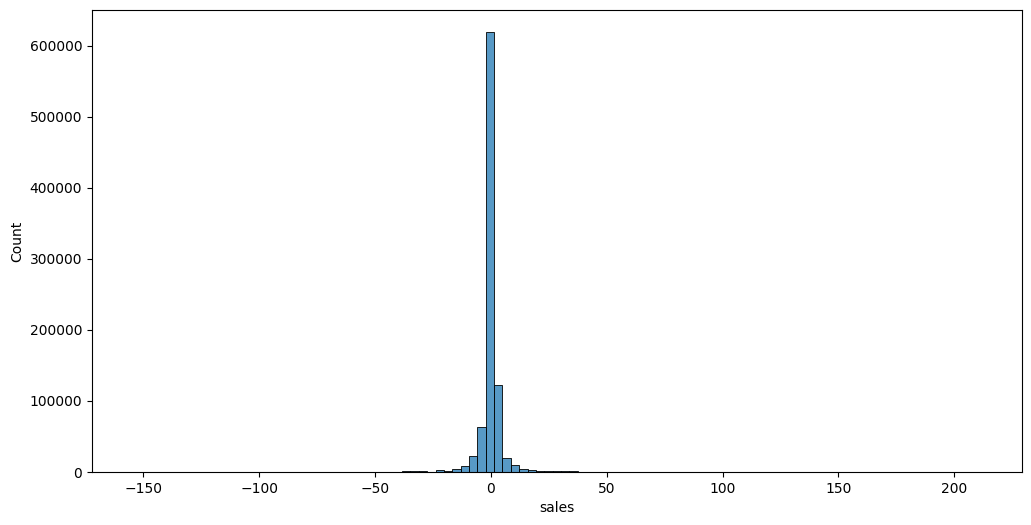

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot((y_val - preds.sales), bins=101)

<Axes: xlabel='sales', ylabel='sales'>

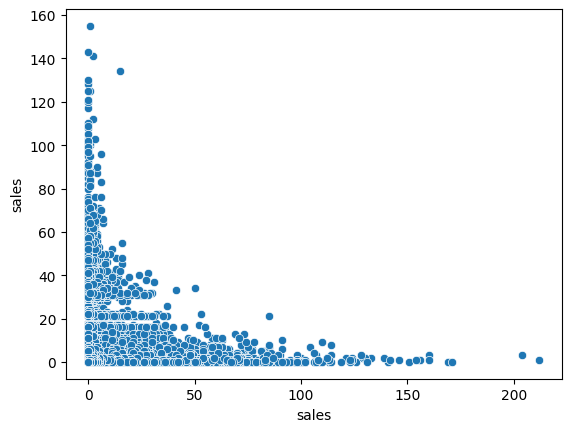

In [ ]:
sns.scatterplot(x=y_val, y=preds)

Получившаяся модель оказалась хуже константной😅. Попробую связку моделей. Классификация (купили больше 0), если да, то уже регрессия.

In [ ]:
del preds, model

In [ ]:
sales = pd.read_csv(r'./data/catboost_train.csv', index_col=0)

sales['snap'] = sales['snap'].astype('int8')
sales['is_event'] = sales['is_event'].astype('int8')
sales['is_christmas_day'] = sales['is_christmas_day'].astype('int8')
sales['wday'] = sales['sales'].astype('int8')
sales['month'] = sales['month'].astype('int16')
sales['sales'] = sales['sales'].astype('int16')
sales['lag_1'] = sales['lag_1'].astype('int16')
sales['lag_3'] = sales['lag_3'].astype('int16')
sales['lag_7'] = sales['lag_7'].astype('int16')
sales['lag_14'] = sales['lag_14'].astype('int16')
sales['lag_28'] = sales['lag_28'].astype('int16')

val = sales[sales.d_int.isin(range(sales.d_int.max()-28, sales.d_int.max()+1))]
X_val, y_val = val.drop(columns=['sales', 'd_int']), val.sales
train = sales[~sales.d_int.isin(range(sales.d_int.max()-28, sales.d_int.max()+1))]
X_train, y_train = train.drop(columns=['sales', 'd_int']), train.sales

del sales

In [ ]:
cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 
                'state_id', 'wday', 'month', 'is_event', 'is_christmas_day', 'snap']

classifier_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 2,
    'iterations': 250,
    'random_strength': 1,
    'bagging_temperature': 0.5,
    'verbose': False,
    'random_seed': 33,
    'use_best_model': True,
    'task_type': 'GPU',
    'cat_features': cat_features,
    'has_time': True
}

classifier = CatBoostClassifier(**classifier_params)

In [ ]:
classifier.fit(
    X_train, (y_train>0).astype(int),
    eval_set=(X_val, (y_val>0).astype(int)),
    early_stopping_rounds=50,
    verbose=True
)

In [ ]:
classifier.save_model(r'./models/classifier.cbm')

In [ ]:
classifier.load_model(r'./models/classifier.cbm')

In [ ]:
cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 
                'state_id', 'wday', 'month', 'is_event', 'is_christmas_day', 'snap']

regressor_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.02,
    'depth': 6,
    'l2_leaf_reg': 2,
    'iterations': 2000,
    'random_strength': 1,
    'bagging_temperature': 0.5,
    'verbose': False,
    'random_seed': 33,
    'use_best_model': True,
    'task_type': 'GPU',
    'cat_features': cat_features,
    'has_time': True
}

regressor = CatBoostRegressor(**regressor_params)

In [ ]:
train_mask = y_train > 0
val_mask = y_val > 0

In [ ]:
regressor.fit(
    X_train[train_mask], y_train[train_mask],
    eval_set=(X_val[val_mask], y_val[val_mask]),
    early_stopping_rounds=50,
    verbose=True
)

0:	learn: 6.1294345	test: 4.8703253	best: 4.8703253 (0)	total: 689ms	remaining: 22m 57s
1:	learn: 6.0233147	test: 4.7829897	best: 4.7829897 (1)	total: 930ms	remaining: 15m 28s
2:	learn: 5.9194217	test: 4.6995106	best: 4.6995106 (2)	total: 1.26s	remaining: 14m 1s
3:	learn: 5.8179470	test: 4.6158614	best: 4.6158614 (3)	total: 1.5s	remaining: 12m 30s
4:	learn: 5.7185584	test: 4.5360055	best: 4.5360055 (4)	total: 1.83s	remaining: 12m 12s
5:	learn: 5.6214566	test: 4.4551213	best: 4.4551213 (5)	total: 2.08s	remaining: 11m 30s
6:	learn: 5.5264490	test: 4.3783760	best: 4.3783760 (6)	total: 2.41s	remaining: 11m 25s
7:	learn: 5.4336391	test: 4.3015993	best: 4.3015993 (7)	total: 2.64s	remaining: 10m 57s
8:	learn: 5.3426692	test: 4.2277078	best: 4.2277078 (8)	total: 2.97s	remaining: 10m 57s
9:	learn: 5.2533399	test: 4.1529876	best: 4.1529876 (9)	total: 3.21s	remaining: 10m 39s
10:	learn: 5.1663185	test: 4.0828221	best: 4.0828221 (10)	total: 3.54s	remaining: 10m 40s
11:	learn: 5.0805835	test: 4.010

In [ ]:
def recursive_forecast_batch_c_r(
    classifier,
    regressor,
    history_df,
    future_df,
    group_cols=["item_id", "store_id"],
    target_col="sales",
    lag_cols=(1, 3, 7, 14, 28),
    rolling_windows=(7, 14, 28)
):
    left = history_df.d_int.max()-30
    right = history_df.d_int.max()
    history_df = history_df[history_df.d_int.isin(range(left, right+1))].copy()

    history_df = history_df.sort_values(list(group_cols) + ["d_int"])
    future_df = future_df.sort_values(list(group_cols) + ["d_int"])

    for cur_date in np.sort(future_df["d_int"].unique()):
        day_df = future_df[future_df["d_int"] == cur_date].copy()
        
        for lag in lag_cols:
            lag_df = history_df.loc[
                history_df["d_int"] == cur_date - lag,
                ["item_id", "store_id", target_col]
            ].rename(columns={target_col: f"lag_{lag}"})

            day_df = day_df.merge(lag_df, on=["item_id", "store_id"], how="left")

        for rol in rolling_windows:
             roll_df = history_df \
                    .groupby(group_cols) \
                    .tail(rol) \
                    .groupby(group_cols) \
                    .sales \
                    .mean()\
                    .reset_index(name=f"rolling_mean_{rol}")
             day_df = day_df.merge(roll_df, on=group_cols, how="left")

        p = classifier.predict_proba(day_df.drop(columns='d_int'))[:, 1]
        y_hat = regressor.predict(day_df.drop(columns='d_int'))

        y_pred = p * y_hat
        y_pred = np.clip(y_pred, 0, None)
        day_df.loc[:, 'sales'] = y_pred
        
        history_df = pd.concat((history_df, day_df), axis=0)
    
    return history_df[history_df.d_int >= future_df.d_int.min()]

In [ ]:
X_val, y_val = val.drop(columns=['sales']), val.sales
X_val = X_val.drop(columns=['lag_1', 'lag_3', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28'])

del X_train, y_train, val

In [ ]:
preds = recursive_forecast_batch_c_r(classifier, regressor, train, X_val)

In [ ]:
mean_absolute_error(preds.sales, y_val)

2.162225269189185

Модели машинного обучения на табличных признаках показали качество ниже простых бейзлайнов (например, константного предсказания). Это связано с высокой долей нулевых значений в продажах и сильной зависимостью данных от временной динамики и сезонных эффектов. Данные модели не являлись основными в рамках работы и рассматривались скорее как дополнительный эксперимент. Основной акцент был сделан на моделировании временных рядов, что показало более адекватные результаты для задачи прогнозирования продаж